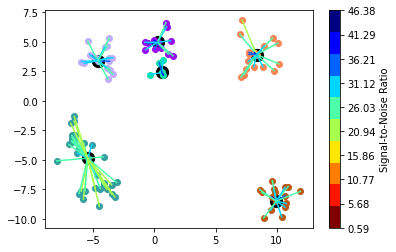

0.7517490386962891
{'Cluster Head': 'client84', 'Members': ['client6', 'client7', 'client13', 'client40', 'client41', 'client48', 'client52', 'client60', 'client62', 'client72', 'client80', 'client82', 'client88', 'client92', 'client96', 'client99'], 'SNR': [22.11178644794321, 22.385403860684427, 23.140925592389834, 22.463428958804343, 25.741378039256116, 33.76411926878438, 30.47356568236747, 25.172262201124973, 18.96445569966997, 29.84326640255828, 25.428856429776186, 40.75218623410015, 27.3554367230914, 22.10784095134031, 33.54477211271933, 30.44163814809608], 'CSI': [0.9668465274886218, 0.7416124581443229, 0.6780051134845079, 0.7954199267755754, 0.17358048649068702, 0.9390113876941805, 0.47562512155901393, 0.49519273126796703, 0.27396677912134715, 0.2844102679125803, 0.2904221737529691, 0.41659987502113016, 0.2892950646275263, 0.8421615998198703, 0.6740615669572215, 0.3106998394870252]}


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from ipynb.fs.full.K_clusters import cluster_former
from copy import deepcopy

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 50
        self.rounds = 200
        self.epochs = 5
        self.local_batches = 64
        self.lr = 0.01
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'iid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.numclusters=4

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)
# global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) """

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
def fedprox(params,global_params):
    global_param=[]
    ind=0
    for gp in global_params:
        global_param.append(gp)
    for p in params:
    #                 print(p.grad)
        lr=0.001
        mu=0.1
        if(p.grad is None):
            continue
        grad=p.grad.data #batch gradients
        p.data.sub_(lr,(grad+mu*(p.data.clone()-global_param[ind].data.clone())))
        ind+=1
    return(p)

In [9]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu,head):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    head['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                #client['optim'].zero_grad()
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                #client['optim'].step()
                params=client['model'].parameters()
                gp=head['model'].parameters()
                params=fedprox(params,gp) 
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    head['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [10]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return([100. * correct / len(test_loader.dataset),test_loss])

In [11]:
torch.manual_seed(args.torch_seed)

In [12]:
def distort(neighbours,snrs):
    ind=0
    poptim=2
    csi=random.random()
    distorted_models=[]
    for client in neighbours:
        snr=snrs[ind]
        ind+=1
        snr__=10**(snr/10)
        absh=csi*poptim/snr__
        x=random.uniform(0,absh)
        y=math.sqrt(absh*absh-x*x)
        std=math.sqrt(poptim/snr__*absh*absh) #channel noise
        h=complex(x,y)
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
        
        distorted_models.append(client)
    return(distorted_models)
        

In [13]:
def decentralized(clients,snrs,weights):
    big_daddy_of_distorted_models=[]
    for client in clients:
        distorted_models=[]
        snr_list=[]
        for snr in snrs:
            if(client['hook'].id in snr):
                snr_list.append(snr[2])
        neighbours_c = [x for x in clients if x != client]
        neighbours={}
        jjj=[jkl for jkl in range(len(neighbours_c))]
        
        dictionary = dict(zip(jjj, neighbours_c))
        #for jjj in range(len(neighbours_c)):
        #   neighbours[jjj].append(neighbours_c[jjj])
        distorted_models=distort(neighbours,snr_list)
        distorted_models.append(client)
        big_daddy_of_distorted_models.append(distorted_models)
    
    
    weight_final1=[]
    for oho in big_daddy_of_distorted_models:
        weight_final=[]
        for comeon in oho:
            for w in weights:
                if(comeon['hook'].id==w[0]):
                    weight_final.append(w[1])
        weight_final1.append(weight_final)
    
    final_heads=[]
    nets=[]
    ind=0
    for client in clients:
        for oof in big_daddy_of_distorted_models:
            if(client==oof[0]):
#                 print(client)
#                 print("shut up")
#                 print(distorted_models)
#                 print("shut up")
#                 print(weight_final1)
                
                overall=Net()
                overall=averageModelscluster(overall,distorted_models,weight_final1[ind])
                client['model'].load_state_dict(overall.state_dict())
                ind+=1
                final_heads.append(client)
                nets.append(overall)
    
    return(final_heads,nets)
        
            
            

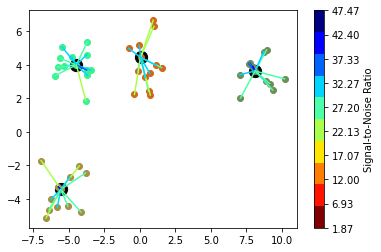

0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.332608


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/iiitd/.local/lib/python3.8/site-packages/syft/generic/frameworks/hook/hook.py:165: UserWarning: This overload of sub_ is deprecated:
	sub_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	sub_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/python_arg_parser

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.276316
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.266072
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.198455
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.057315

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.275207
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294024
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.253708
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.189052
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.058655

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.322782
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.313338
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.285156
Model client13 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.224192
Model client13 Train Epoch: 5 [0/1216 (0%)

/tmp/ipykernel_686920/1497942811.py:66: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real


Model client20 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.293101
Model client20 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.275940
Model client20 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.221257
Model client20 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.102039

Power Allocated= 4.52508102722464
CSI= 0.22569911582130064
SNR= 28.985700049696103
Client: client26
Model client26 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303117
Model client26 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.321973
Model client26 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.221740
Model client26 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.211729
Model client26 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.974733

Power Allocated= 7.947178767984037
CSI= 0.9914932017338863
SNR= 25.738885248898967
Client: client33
Model client33 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.307662
Model client33 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.318459
Model client33 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290829
Model client33 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.263117
Model client33 Train Epoch: 5 [

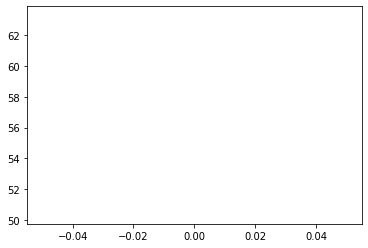

ROUND 0
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.295218
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.231253
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.001358
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.603474
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.580218

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299271
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.258809
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.061612
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.442453
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.040602

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.61081172350400

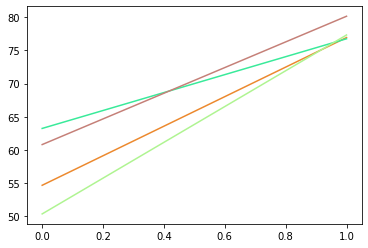

ROUND 1
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.274336
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.148411
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.703400
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.139031
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.450307

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.240306
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.200894
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.873671
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.402480
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.998371

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.228684
Model client13 Train Epoch: 2 [0/1

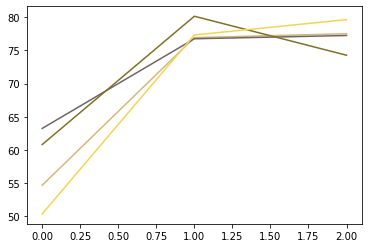

ROUND 2
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.207474
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.085688
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.696154
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.098850
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.623506

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.232234
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.108265
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.720213
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.349079
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.304764

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.234315
Model client13 Train Epoch: 2 [0/1

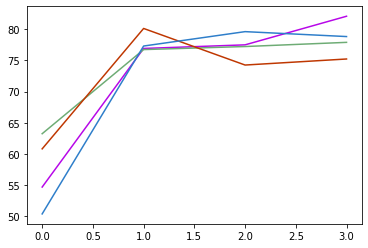

ROUND 3
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.244666
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.178956
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.892744
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.661865
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.357138

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.223728
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.151397
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.915820
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.424025
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.733910

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.221725
Model client13 Train Epoch: 2 [0/1

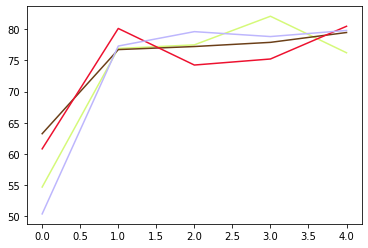

ROUND 4
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.219107
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.119811
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.614035
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.851565
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.225416

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.206007
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.116540
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.676818
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.318077
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.862473

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.61081172350400

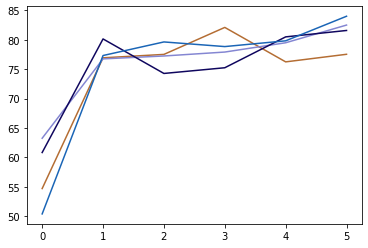

ROUND 5
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.138007
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.998636
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.487287
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.540943
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.342284

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.150793
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.017511
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.651150
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.429548
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.549682

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.114060
Model client13 Train Epoch: 2 [0/1

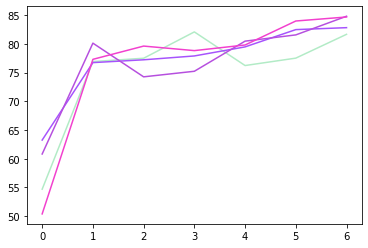

ROUND 6
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.133836
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.007264
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.715492
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.557893
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.200220

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.049438
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.724759
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.327506
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.138615
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.759639

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.61081172350400

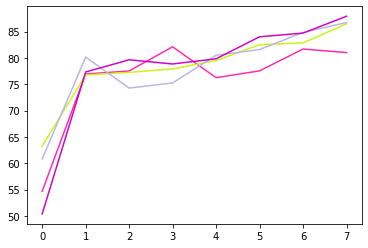

ROUND 7
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.049071
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.735020
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.286538
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.933291
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.690286

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.941719
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.697538
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.189797
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.058113
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.621772

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.059178
Model client13 Train Epoch: 2 [0/1

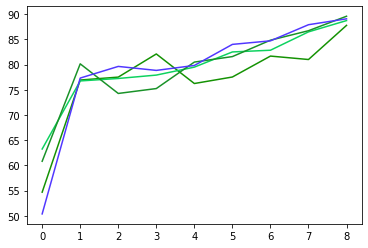

ROUND 8
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.830302
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.524677
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.880594
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.794688
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.370792

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.814927
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.188321
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.813946
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.942452
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.441141

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.984061
Model client13 Train Epoch: 2 [0/1

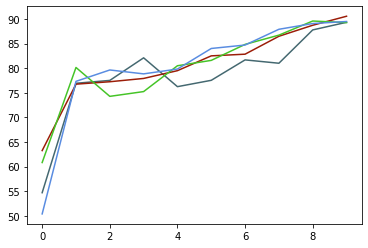

ROUND 9
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.751534
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.296044
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.759650
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.851533
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.936349

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.699510
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.069142
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.809037
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.534498
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.538834

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.718948
Model client13 Train Epoch: 2 [0/1

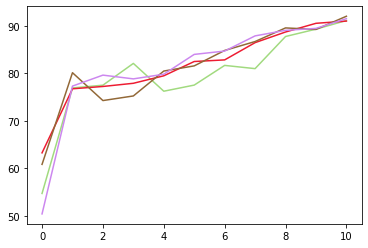

ROUND 10
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.530540
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.917397
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.422958
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.466813
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.763138

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.618240
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.975929
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.145358
Model client13 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.350211
Model client13 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.955393

Power Allocated= 1.61081172

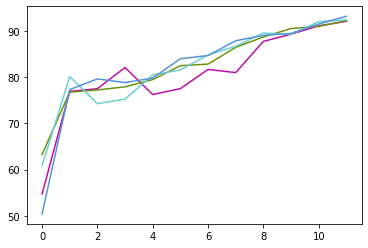

ROUND 11
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.428156
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.656172
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.875989
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.691685
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.077645

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.520465
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.907681
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.561408
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.715634
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.142391

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

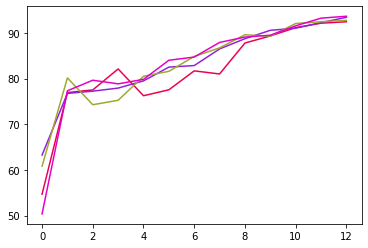

ROUND 12
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.870687
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.991801
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.714675
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.999895
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.715774

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.365218
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.769612
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.715289
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.929753
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.947242

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.425014
Model client13 Train Epoch: 2 [0/

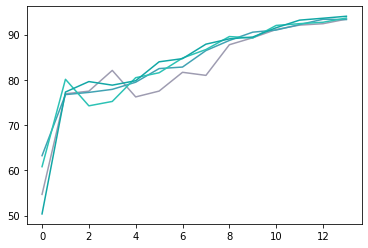

ROUND 13
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.331161
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.845048
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.224147
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.235042
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.149893

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.309180
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.767330
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.303534
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.420748
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.817615

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

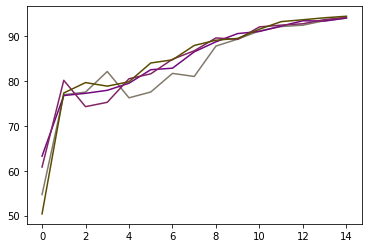

ROUND 14
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.215315
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.581410
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.606072
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.726584
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.741809

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.229731
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.698794
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.671837
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.640550
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.601564

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.218983
Model client13 Train Epoch: 2 [0/

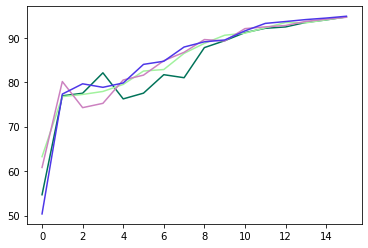

ROUND 15
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.227802
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.685040
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.574195
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.714670
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.514507

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.077835
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.552671
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.234279
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.175125
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.172177

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

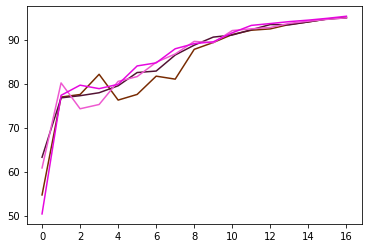

ROUND 16
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.025005
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.488383
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.351191
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.917651
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.805154

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.089402
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.530661
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.601011
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.347278
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.795952

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

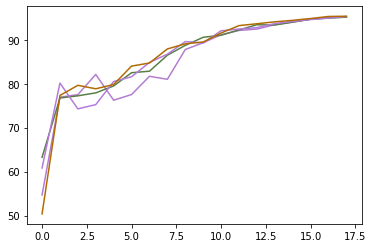

ROUND 17
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.347482
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.488223
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.648224
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.450631
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.126911

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.957704
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.353181
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.520699
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.323716
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.737217

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.099784
Model client13 Train Epoch: 2 [0/

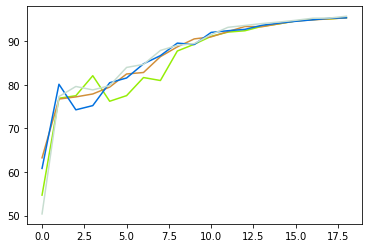

ROUND 18
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.240819
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.428411
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.254979
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.511614
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.105962

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.066226
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.389795
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.208218
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.296606
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.177499

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.017473
Model client13 Train Epoch: 2 [0/

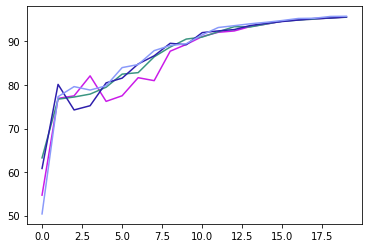

ROUND 19
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.928834
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.538865
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.933674
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.065698
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.944678

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.962852
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.525952
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.376326
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.480995
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.512600

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

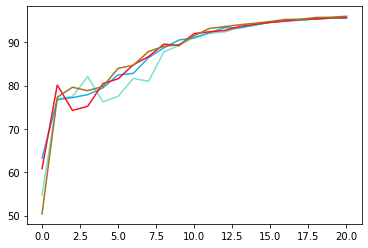

ROUND 20
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.962837
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.406606
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.226893
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.167473
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.209502

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040025
CSI= 0.1361480243830283
SNR= 24.04818173100646
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.956307
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.284497
Model client15 Train Epoch: 3 [0/1216 (0%)]	L

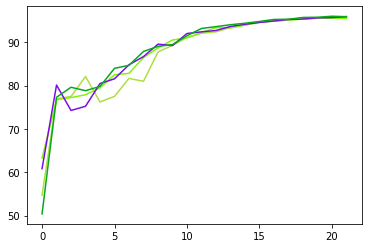

ROUND 21
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.752331
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.380303
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.450247
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.669810
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.427301

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.675477
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.222531
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.180407
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.909463
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.434094

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.946483
Model client13 Train Epoch: 2 [0/

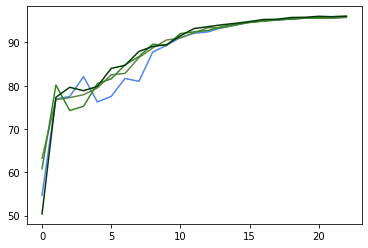

ROUND 22
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.798872
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.473350
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.415216
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.660393
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.032667

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.946814
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.293761
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.173605
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.413702
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.854392

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.908012
Model client13 Train Epoch: 2 [0/

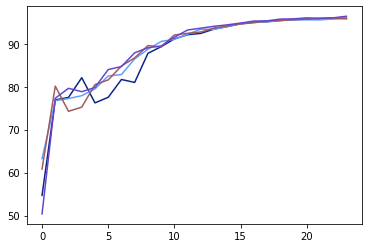

ROUND 23
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.826557
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.331759
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.365618
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.129260
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.416742

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.683544
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.260203
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.209895
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.475159
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.724371

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.733852
Model client13 Train Epoch: 2 [0/

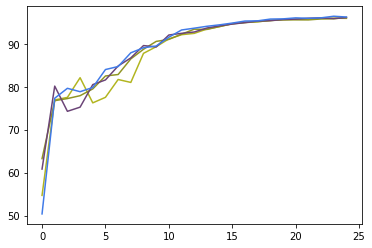

ROUND 24
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.760130
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.374401
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.273668
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.349903
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.229014

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.769199
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.306927
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.377820
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.319317
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.497474

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.839886
Model client13 Train Epoch: 2 [0/

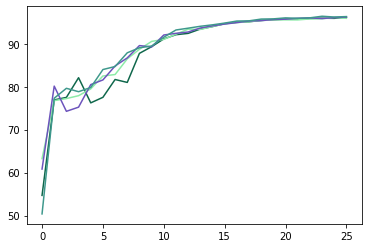

ROUND 25
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.892902
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.483773
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.390541
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.616246
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.638392

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.859638
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.313945
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.602021
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.226833
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.516675

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.215397
Model client13 Train Epoch: 2 [0/

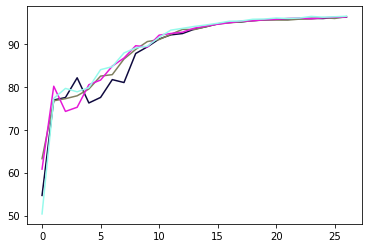

ROUND 26
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.734644
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.439559
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.229861
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.294345
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.875446

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.800533
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.230067
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.427764
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.725620
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.953654

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

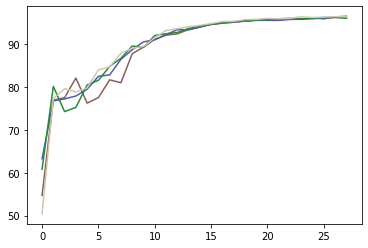

ROUND 27
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.712632
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.188100
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.217403
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.597246
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.858856

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.660223
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.381057
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.647982
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.360297
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.155695

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

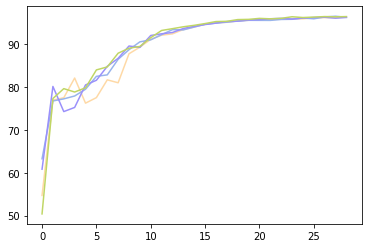

ROUND 28
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.649271
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.267828
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.320782
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.395065
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.414666

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.736558
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.335318
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.307233
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.606337
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.764116

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

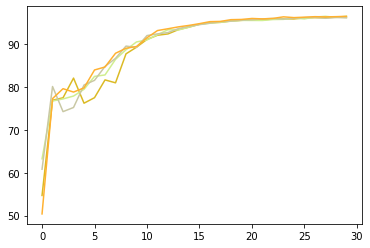

ROUND 29
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.996588
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173269
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.469527
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.056163
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.506568

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.722482
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.218742
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.212908
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.517246
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.820251

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.688576
Model client13 Train Epoch: 2 [0/

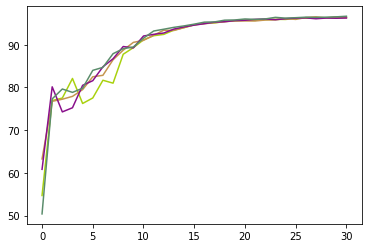

ROUND 30
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.707611
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.230589
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.347720
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.273696
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.336245

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.758466
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159596
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.229304
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.870198
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.252146

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.597990
Model client13 Train Epoch: 2 [0/

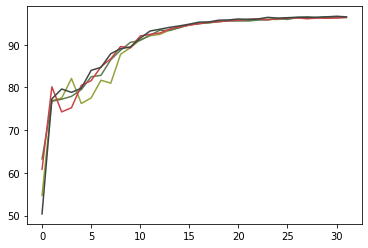

ROUND 31
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.644850
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197218
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.176401
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.277996
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.863890

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.586941
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.224450
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.220829
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.418968
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.346385

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.698835
Model client13 Train Epoch: 2 [0/

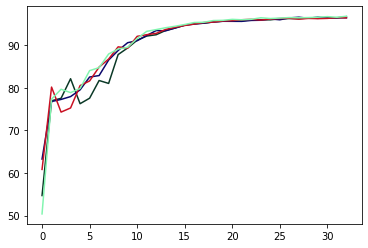

ROUND 32
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.653122
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.247871
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.579605
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.402345
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.257600

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.842495
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.241909
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.417178
Model client13 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.339647
Model client13 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.497850

Power Allocated= 1.61081172

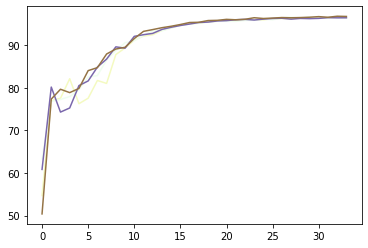

ROUND 33
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.878391
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.382941
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.462466
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.254872
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.289978

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.623601
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.315986
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.305236
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.506122
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.716289

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.794343
Model client13 Train Epoch: 2 [0/

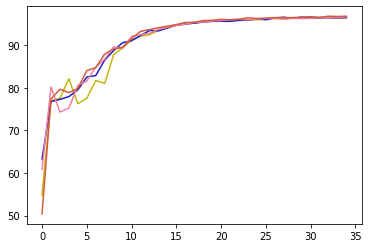

ROUND 34
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.206019
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.250592
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.556300
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.420421
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.206596

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.567025
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.239604
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.175750
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.343135
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.378287

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.709161
Model client13 Train Epoch: 2 [0/

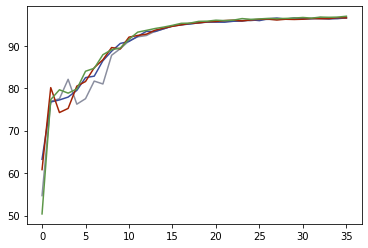

ROUND 35
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.632683
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.177895
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.382310
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.855962
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.163021

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.627635
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176178
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.349697
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.220122
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.739787

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.804626
Model client13 Train Epoch: 2 [0/

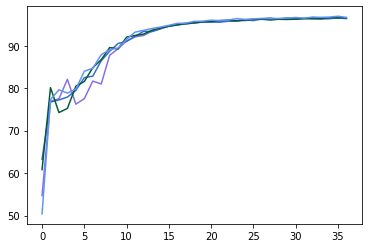

ROUND 36
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.646653
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.436811
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.260518
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.515140
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.202372

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.604214
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.200581
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.513378
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.436260
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.505664

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.863832
Model client13 Train Epoch: 2 [0/

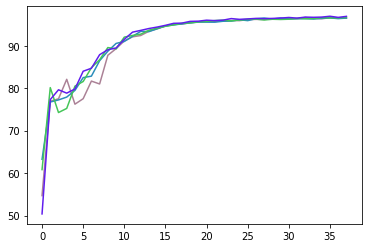

ROUND 37
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.745975
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.543527
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.555138
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.694294
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.745121

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.959270
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.234550
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.331232
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.085334
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.729020

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.176575
Model client13 Train Epoch: 2 [0/

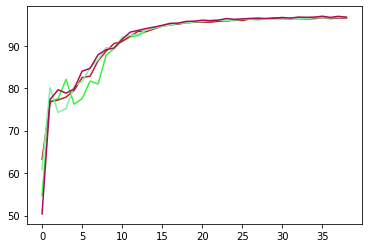

ROUND 38
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.453843
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140236
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.235151
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.491357
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.247528

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.674916
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.313165
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.393007
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.294864
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.308690

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.558768
Model client13 Train Epoch: 2 [0/

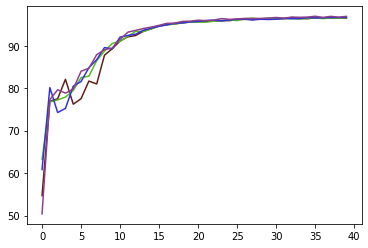

ROUND 39
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.645242
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.203162
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.386149
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.117770
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.689375

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.639132
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.308133
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.415009
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.570043
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.760882

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.587612
Model client13 Train Epoch: 2 [0/

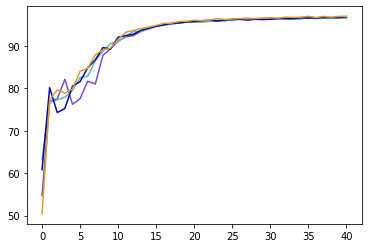

ROUND 40
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.637610
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.220736
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.357811
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.187562
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.636137

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.507624
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165559
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.259514
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.218061
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.363810

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.626584
Model client13 Train Epoch: 2 [0/

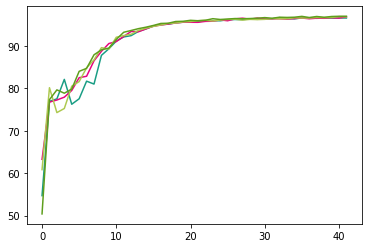

ROUND 41
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.615636
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.304352
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.410867
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.684778
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.505563

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.568951
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116835
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.096600
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.657979
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.150297

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.535099
Model client13 Train Epoch: 2 [0/

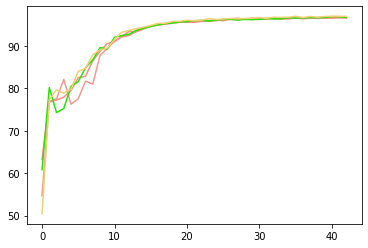

ROUND 42
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.736362
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.348356
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.297915
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.214722
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.178762

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.584451
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.235836
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.243786
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.247749
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.322745

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.562616
Model client13 Train Epoch: 2 [0/

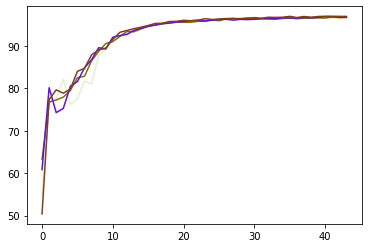

ROUND 43
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.596894
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.222753
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.318236
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.095820
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.030333

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.587151
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170725
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.403544
Model client13 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.202162
Model client13 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.053270

Power Allocated= 1.61081172

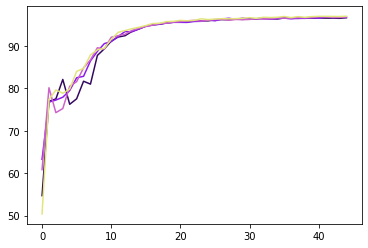

ROUND 44
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.653470
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.364046
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.324443
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.385246
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.892906

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.537748
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.270343
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.252052
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.822106
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.054886

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

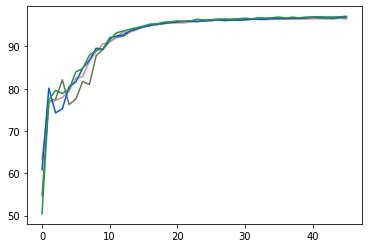

ROUND 45
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.768991
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.301234
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.322676
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.203777
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.259299

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.692158
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110694
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.237841
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.391836
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.027732

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.692076
Model client13 Train Epoch: 2 [0/

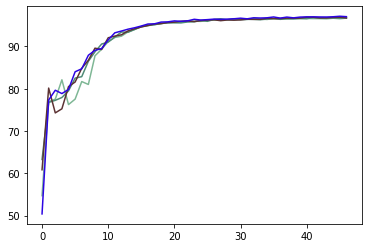

ROUND 46
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.552631
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.218128
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.477591
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.367153
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.965593

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.528549
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212939
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.171636
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.474354
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.052417

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.661198
Model client13 Train Epoch: 2 [0/

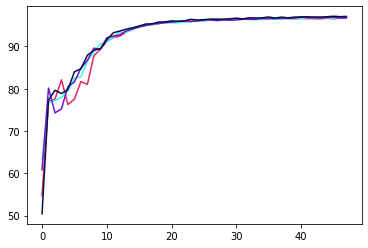

ROUND 47
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.630970
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.259848
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.326074
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.298194
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.317253

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.590625
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.367434
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.199040
Model client13 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.484805
Model client13 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.307101

Power Allocated= 1.61081172

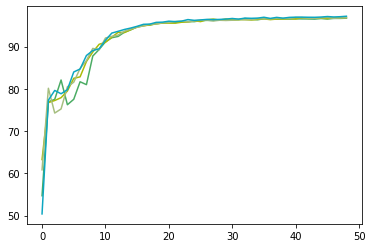

ROUND 48
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.678584
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.270965
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.209692
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.517424
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.414566

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.564400
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.206370
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174142
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.261610
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.604141

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

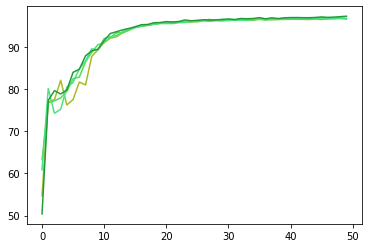

ROUND 49
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.760109
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.184919
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.217786
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.089504
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.826027

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.514687
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.241549
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.214371
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.273006
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.456129

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.581235
Model client13 Train Epoch: 2 [0/

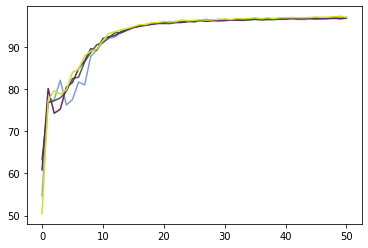

ROUND 50
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.511317
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197833
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.251851
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.395889
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.430423

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.630892
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.206711
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.083003
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.676601
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.933026

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.770708
Model client13 Train Epoch: 2 [0/

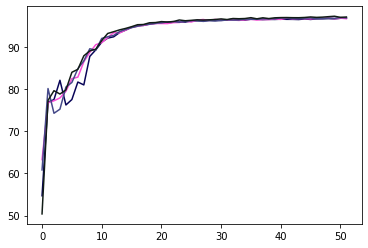

ROUND 51
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.506530
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.250910
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053282
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.091155
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.905553

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.567115
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246482
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.197476
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.472655
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.325537

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.665174
Model client13 Train Epoch: 2 [0/

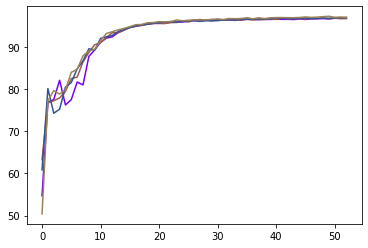

ROUND 52
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.464098
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136060
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.147500
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.605081
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.663501

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.451209
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.255409
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.260979
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.545658
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.214261

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.601688
Model client13 Train Epoch: 2 [0/

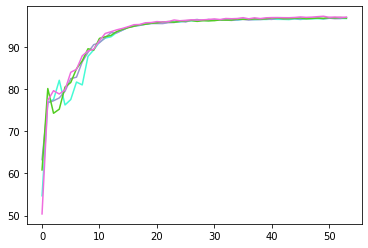

ROUND 53
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.472777
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.191786
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.382447
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.394518
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.350563

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.569557
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.297672
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.568156
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.352702
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.642654

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.901002
Model client13 Train Epoch: 2 [0/

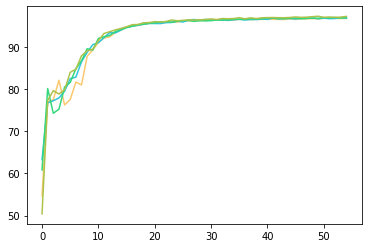

ROUND 54
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.568480
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.366846
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.355431
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.268417
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.266304

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.545646
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189540
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.269389
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.546212
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.835544

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.550367
Model client13 Train Epoch: 2 [0/

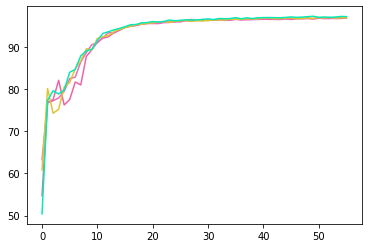

ROUND 55
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.466086
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.273244
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.088741
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.412422
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.188810

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.624007
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.196754
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104260
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.544508
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.535591

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.726003
Model client13 Train Epoch: 2 [0/

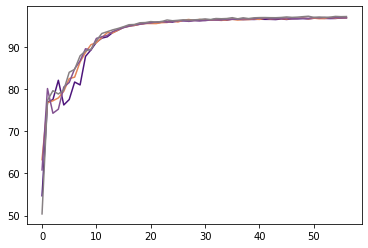

ROUND 56
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.421403
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.240889
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.190194
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.214339
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.088389

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.410091
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.204639
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.326012
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.275173
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.871430

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.438937
Model client13 Train Epoch: 2 [0/

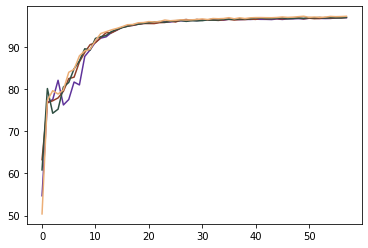

ROUND 57
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513203
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212413
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.193909
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.128101
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.025876

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.460997
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.401064
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.422662
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.198149
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.503971

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.575752
Model client13 Train Epoch: 2 [0/

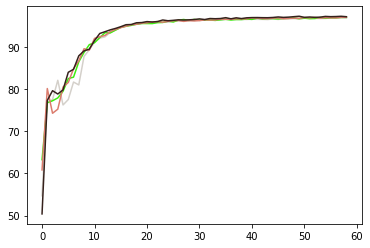

ROUND 58
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.498373
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.220739
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.103894
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.472419
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.472263

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389675
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079085
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110800
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.304517
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.518790

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.598384
Model client13 Train Epoch: 2 [0/

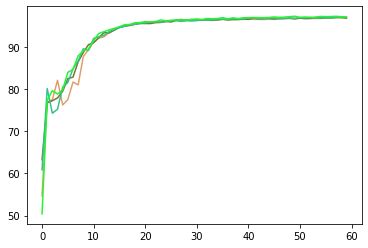

ROUND 59
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.554640
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179226
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.400299
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.481641
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.563491

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.548749
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102760
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.247462
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.068399
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.173451

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

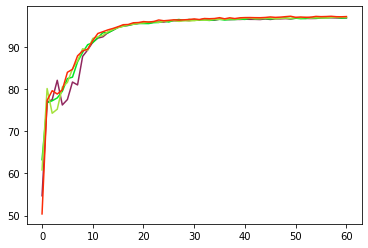

ROUND 60
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.631410
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120106
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.718091
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.275536
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.540261

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.656417
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.392053
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.130319
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.253870
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.936982

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.534594
Model client13 Train Epoch: 2 [0/

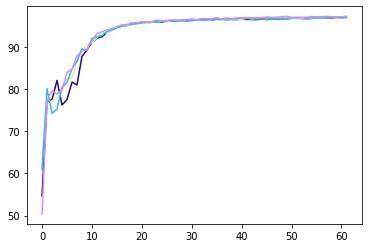

ROUND 61
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.581226
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093554
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.320534
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.363251
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.932558

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.491961
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136888
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.265670
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.046861
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.216255

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

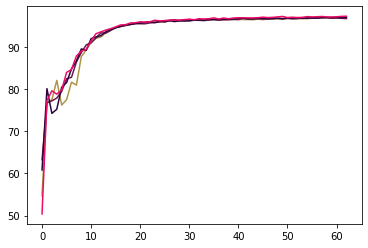

ROUND 62
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.473069
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146639
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.143896
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.035015
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.068506

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.507063
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115383
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.223260
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.533498
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.074341

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.576424
Model client13 Train Epoch: 2 [0/

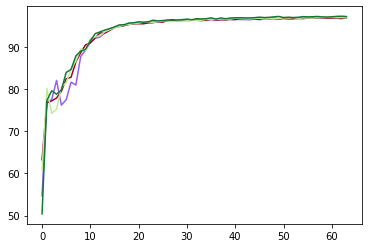

ROUND 63
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.440811
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163484
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.207799
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.228810
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.756617

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.494641
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093293
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.237073
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.192858
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.471112

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

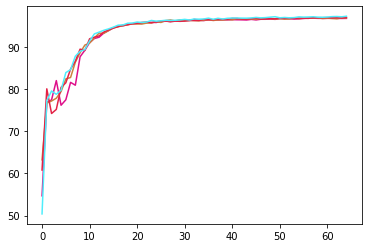

ROUND 64
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.412360
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.194917
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.243618
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.254041
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.393753

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.476756
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.230700
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.177030
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.202377
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.342235

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

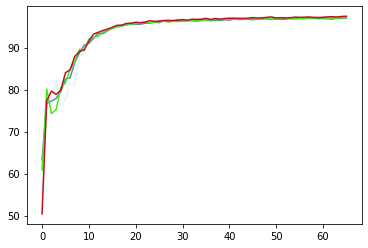

ROUND 65
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.459940
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132032
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.232879
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.494988
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.294770

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.529430
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185983
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119066
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.192208
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.069948

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

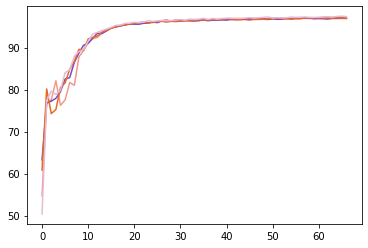

ROUND 66
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.487916
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103652
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.227698
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.779558
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.374112

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.453934
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097632
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.396207
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.557313
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.596478

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.487205
Model client13 Train Epoch: 2 [0/

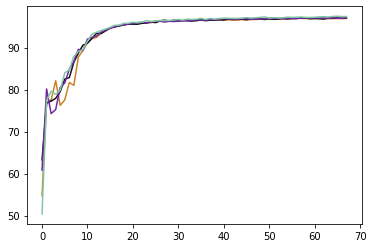

ROUND 67
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.467006
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138571
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038960
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.295445
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.533227

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.419596
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.258845
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.129380
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.751000
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.498519

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.555820
Model client13 Train Epoch: 2 [0/

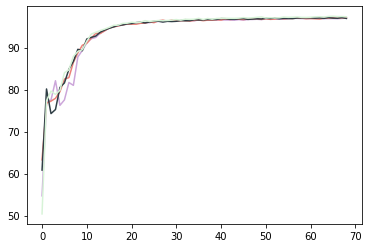

ROUND 68
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.639175
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051876
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.282472
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.147237
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.511546

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.390904
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157808
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.250572
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.103224
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.073614

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

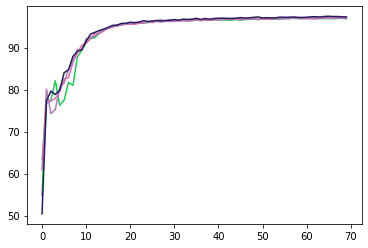

ROUND 69
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.491417
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134233
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.469705
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.082679
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.158194

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.679341
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097511
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.170701
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.166783
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.296669

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

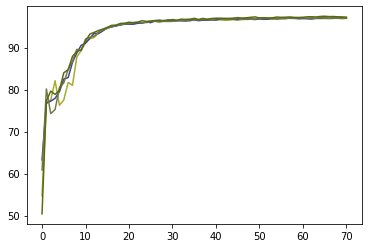

ROUND 70
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.525928
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.249540
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104947
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.088796
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.849429

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.608648
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.398164
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.241797
Model client13 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.624897
Model client13 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.650650

Power Allocated= 1.61081172

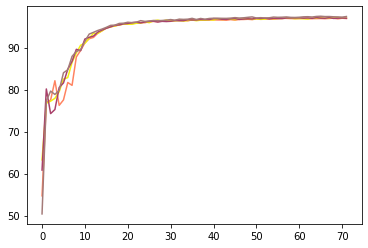

ROUND 71
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.463445
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147897
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117327
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.388126
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.201707

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.530949
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.221300
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.263248
Model client13 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.761582
Model client13 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.595586

Power Allocated= 1.61081172

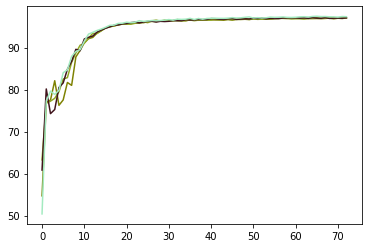

ROUND 72
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.394145
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168592
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.392739
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.540888
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.555002

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.479617
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134379
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.108793
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.157734
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.481757

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.496221
Model client13 Train Epoch: 2 [0/

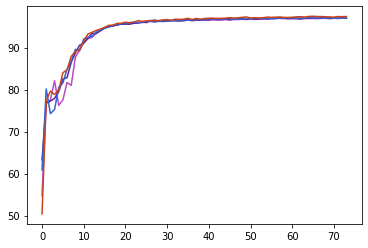

ROUND 73
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.533449
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.207505
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.124669
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.272417
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.670245

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.487245
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173730
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.175049
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.146816
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.578237

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.530963
Model client13 Train Epoch: 2 [0/

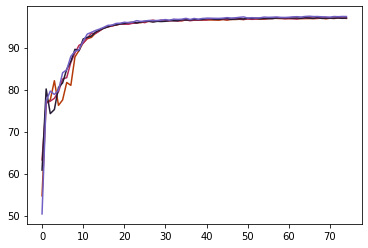

ROUND 74
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.377124
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096598
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069203
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.617700
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.265314

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.454181
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.278378
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.088481
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.348205
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.111631

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.502534
Model client13 Train Epoch: 2 [0/

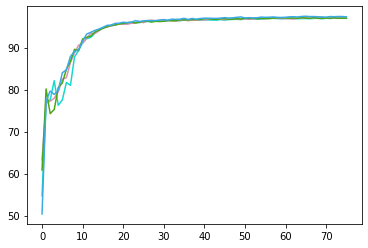

ROUND 75
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.504312
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110453
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069010
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.724917
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.333846

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.598442
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073846
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.065483
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.610795
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.219025

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

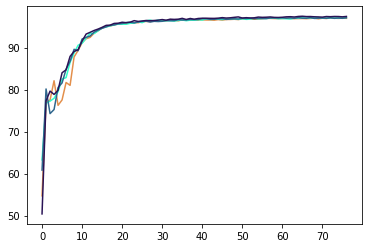

ROUND 76
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.376708
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137018
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.268966
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.658865
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.948716

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.459000
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.303385
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.236036
Model client13 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.480659
Model client13 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.200787

Power Allocated= 1.61081172

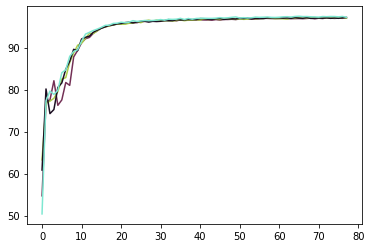

ROUND 77
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.367206
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.207835
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030620
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.378835
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.299544

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.524350
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103194
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.236458
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.081789
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.796826

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

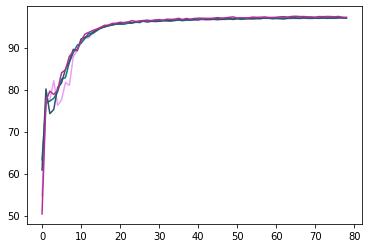

ROUND 78
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.536771
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115632
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.298642
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.305221
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.081393

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.465641
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.177575
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.447106
Model client13 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.294881
Model client13 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.303541

Power Allocated= 1.61081172

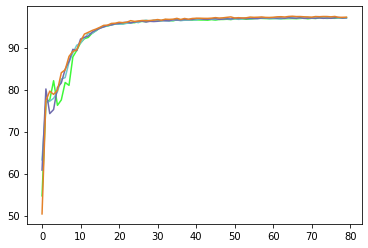

ROUND 79
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.716555
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104983
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.298620
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.082501
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.237746

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.522623
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154373
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.160642
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.529112
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.057300

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.492347
Model client13 Train Epoch: 2 [0/

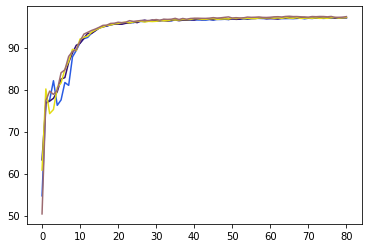

ROUND 80
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.467216
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089309
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.372750
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.379993
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.606255

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.385685
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161091
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.168208
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.675369
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.790258

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

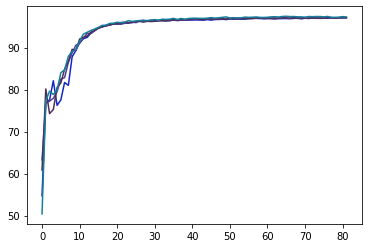

ROUND 81
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.371115
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.144958
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174492
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.892151
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.235329

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.557954
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098199
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.196369
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.323400
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.722452

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

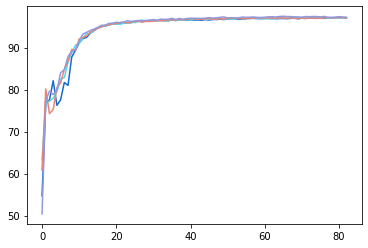

ROUND 82
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.599977
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.198862
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.406489
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.493895
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.632358

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.575262
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.217470
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.124951
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.231681
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.173515

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.473746
Model client13 Train Epoch: 2 [0/

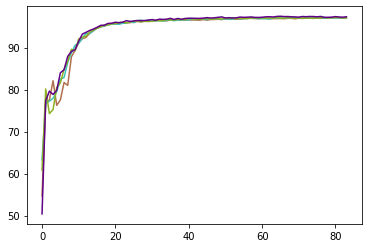

ROUND 83
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.384495
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178946
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.276410
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.356213
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.355369

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.615316
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.328435
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.387846
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.697290
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.822886

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

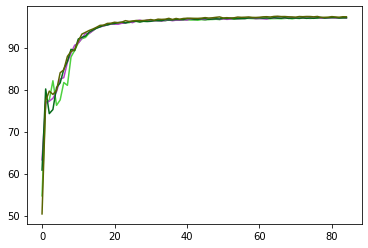

ROUND 84
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.471438
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046844
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026075
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.278243
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.708975

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.372281
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.676738
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.411483
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.971975
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.396396

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.670856
Model client13 Train Epoch: 2 [0/

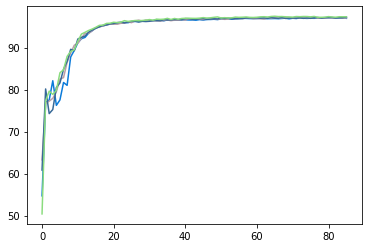

ROUND 85
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.529107
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103895
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.111198
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.200043
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.688837

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.476594
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.240653
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.404426
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.993546
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.528392

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.383497
Model client13 Train Epoch: 2 [0/

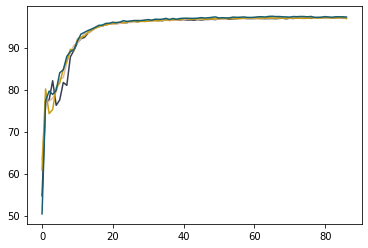

ROUND 86
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.368257
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.122057
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.149859
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.117322
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.598253

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.476083
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.201790
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.074388
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.231623
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.333070

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

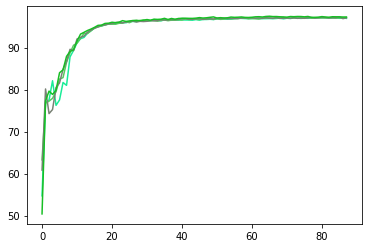

ROUND 87
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.442056
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159975
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064779
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.457074
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.562590

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.422560
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101714
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.150679
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.196779
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.450164

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.489592
Model client13 Train Epoch: 2 [0/

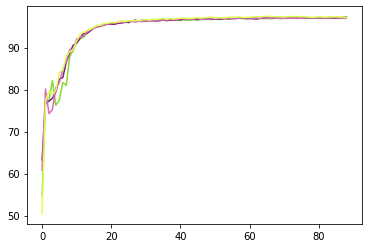

ROUND 88
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.383122
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110666
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.733254
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.363770
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.940199

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040025
CSI= 0.1361480243830283
SNR= 24.04818173100646
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.468175
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113885
Model client15 Train Epoch: 3 [0/1216 (0%)]	L

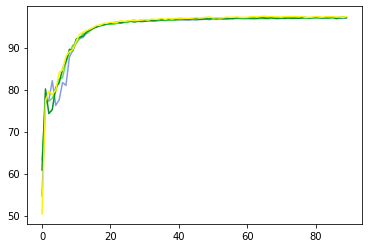

ROUND 89
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.619530
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.187459
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.246450
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.632772
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.733556

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.547442
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173831
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.206402
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.836243
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.485778

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

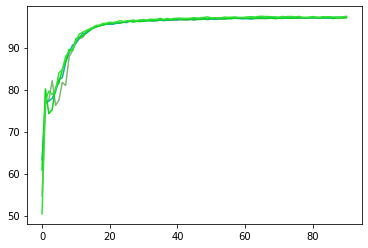

ROUND 90
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.695425
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114807
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134232
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.072528
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.302922

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.465781
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.268163
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.298026
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.510971
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.133134

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.588681
Model client13 Train Epoch: 2 [0/

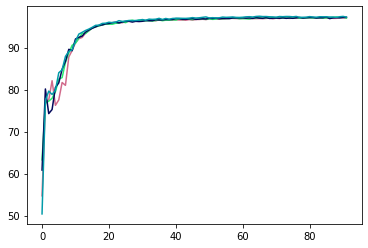

ROUND 91
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.537851
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.311675
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.419982
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.179323
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.261083

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.342234
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.095135
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.609736
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.341273
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.243075

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

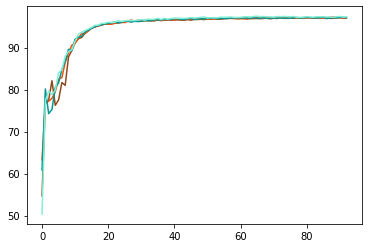

ROUND 92
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.595691
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.199906
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.425057
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.514421
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.998988

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.477782
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.192605
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.283020
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.588375
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.500921

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

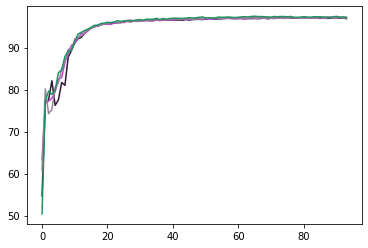

ROUND 93
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.345242
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104495
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121521
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.153779
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.773630

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.378687
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107897
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.289493
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.081967
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.469994

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.526739
Model client13 Train Epoch: 2 [0/

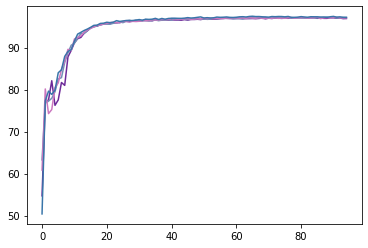

ROUND 94
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.402838
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.463797
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.243562
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.161835
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.420680

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.361710
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115064
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.471897
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.328930
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.038081

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

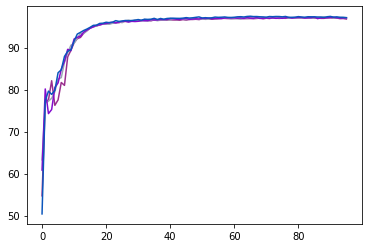

ROUND 95
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.457205
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164008
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.251210
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.852820
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.497102

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.546494
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134746
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.149706
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.148484
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.648338

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.511173
Model client13 Train Epoch: 2 [0/

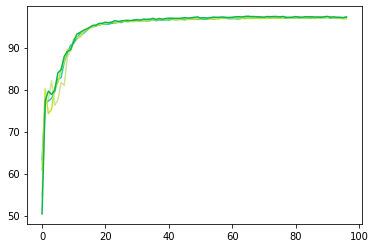

ROUND 96
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.399093
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.225245
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.238899
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.497673
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.311921

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.344520
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141528
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.219792
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.222845
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.864297

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.394762
Model client13 Train Epoch: 2 [0/

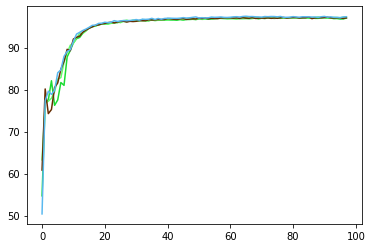

ROUND 97
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.531375
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.253912
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.221486
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.401011
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.401070

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.452450
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.211547
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.510520
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.353317
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.426147

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.448203
Model client13 Train Epoch: 2 [0/

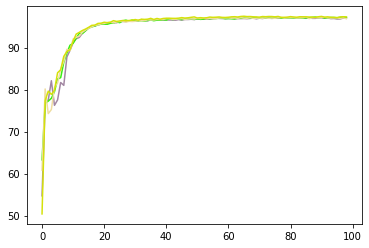

ROUND 98
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.525007
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102921
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.078459
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.942860
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.092129

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.408661
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.229743
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.180015
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.499922
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.710307

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

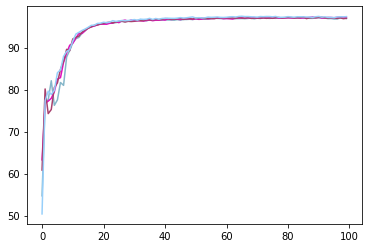

ROUND 99
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.536372
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.426741
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.402214
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.212878
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.808372

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.497181
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082465
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.199519
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.560398
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.876923

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040

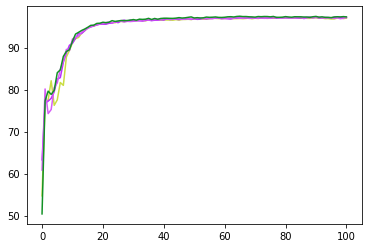

ROUND 100
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.384584
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060897
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102903
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.097185
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.001525

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.495583
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.184472
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.168501
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.196469
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.702768

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.379350
Model client13 Train Epoch: 2 [0

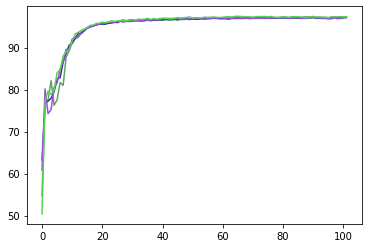

ROUND 101
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.407184
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.150375
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.431339
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.373461
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.135414

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.551365
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160002
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.106623
Model client13 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.336298
Model client13 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.399212

Power Allocated= 1.6108117

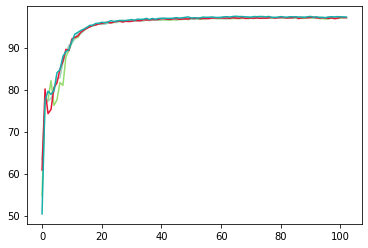

ROUND 102
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.593855
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157008
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.432911
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.312923
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.875597

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.577105
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139444
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.371161
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.261253
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.212235

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.462814
Model client13 Train Epoch: 2 [0

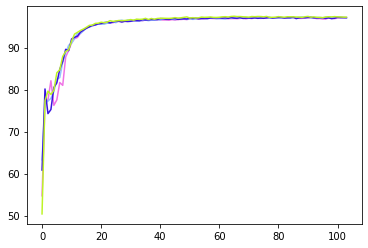

ROUND 103
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327830
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104852
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.382128
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.427338
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.083839

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.460482
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.143455
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.291880
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.455837
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.381343

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.460525
Model client13 Train Epoch: 2 [0

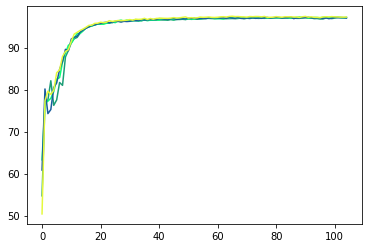

ROUND 104
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.446760
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185031
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.595264
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.175079
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.531541

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.682907
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120523
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.159613
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.573332
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.734572

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

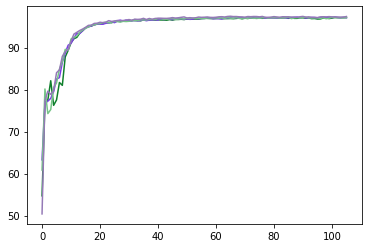

ROUND 105
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.558722
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075055
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.326671
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.789427
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.305586

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.387975
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107466
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.283786
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.624129
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.885973

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.720811
Model client13 Train Epoch: 2 [0

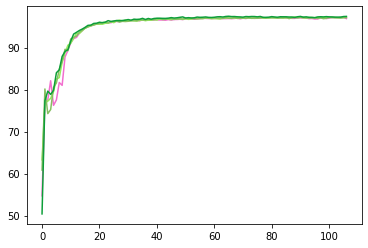

ROUND 106
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.493538
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.080701
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.272134
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.246384
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.469679

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.502681
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.351891
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.332417
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.100363
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.778209

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.518556
Model client13 Train Epoch: 2 [0

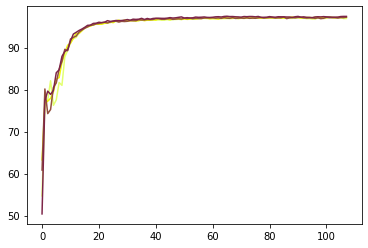

ROUND 107
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.466212
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133982
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.238566
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.232919
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.457449

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.488863
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243559
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.402474
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.784317
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.725205

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.473586
Model client13 Train Epoch: 2 [0

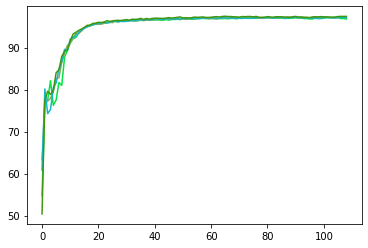

ROUND 108
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.532039
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.184547
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.156322
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.414500
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.096531

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.444635
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.220489
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.448492
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.458765
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.853792

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

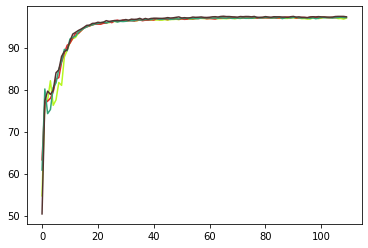

ROUND 109
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.501258
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.238517
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.345857
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.465379
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.401676

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.408786
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.217965
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.280705
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.621008
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.137396

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

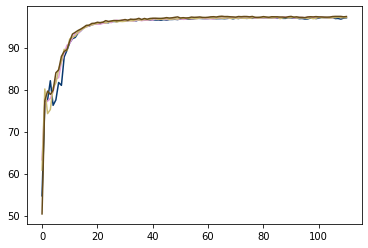

ROUND 110
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.594007
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.220644
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.395529
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.750323
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.682686

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.339511
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.143242
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.315847
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.185656
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.496906

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

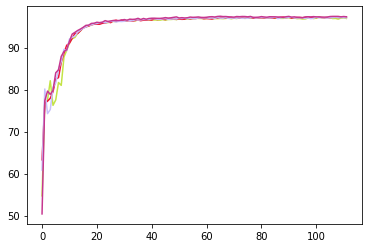

ROUND 111
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.311202
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.298738
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.122418
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.292172
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.321714

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.460330
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.175551
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.301455
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.229834
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.839141

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.432254
Model client13 Train Epoch: 2 [0

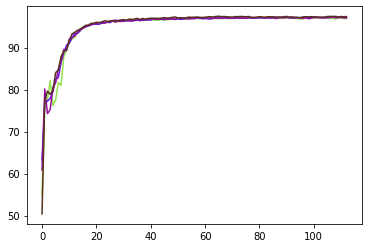

ROUND 112
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.365251
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142559
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.307131
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.547058
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.874946

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.408799
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174234
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.146722
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.193349
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.063509

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

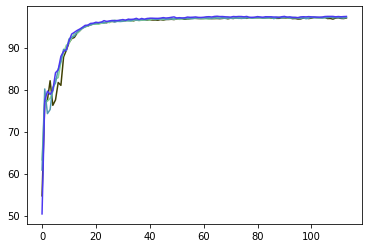

ROUND 113
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.473175
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163797
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.394936
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.294725
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.491276

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.358266
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.432298
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126724
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.690585
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.680776

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.461189
Model client13 Train Epoch: 2 [0

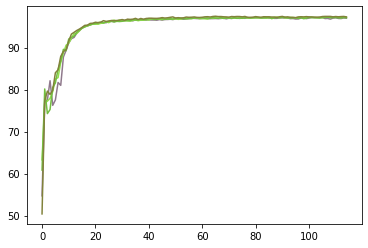

ROUND 114
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.345424
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.249657
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.111698
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.896731
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.607869

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.442996
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170390
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.218711
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.474223
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.400320

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.505775
Model client13 Train Epoch: 2 [0

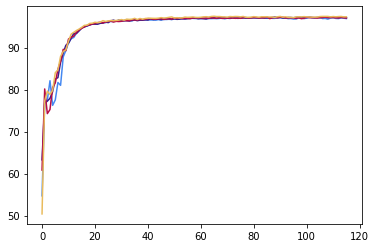

ROUND 115
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.427423
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.318651
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.387556
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.599887
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.502822

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040025
CSI= 0.1361480243830283
SNR= 24.04818173100646
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.453159
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.203972
Model client15 Train Epoch: 3 [0/1216 (0%)]	

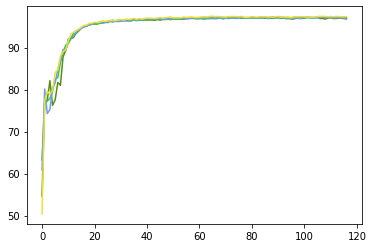

ROUND 116
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.196948
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108912
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.139755
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.383252
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.984220

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.342853
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.251707
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.181519
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.932683
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.436777

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

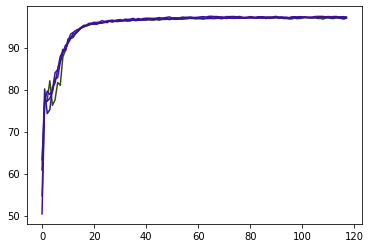

ROUND 117
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.432042
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.334535
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.155663
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.203499
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.212196

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.476661
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.274716
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.140449
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.479506
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.332339

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.478920
Model client13 Train Epoch: 2 [0

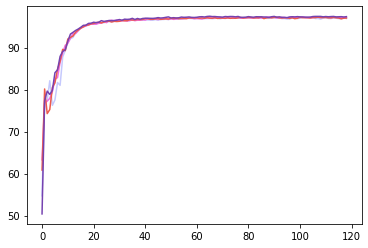

ROUND 118
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.436442
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181357
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.182342
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.172272
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.164615

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.296402
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.144431
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117965
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.342114
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.207880

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.510843
Model client13 Train Epoch: 2 [0

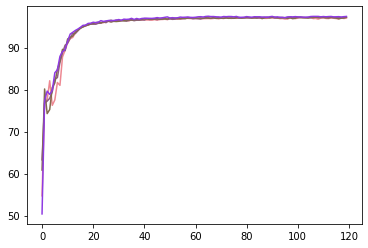

ROUND 119
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.332525
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140901
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092501
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.756622
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.088068

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.301461
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246734
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.106507
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.091746
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.780687

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.400905
Model client13 Train Epoch: 2 [0

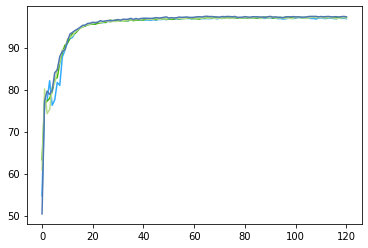

ROUND 120
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.564620
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.341152
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007256
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.154269
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.289227

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.458826
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.171672
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123205
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.471439
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.333965

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.357637
Model client13 Train Epoch: 2 [0

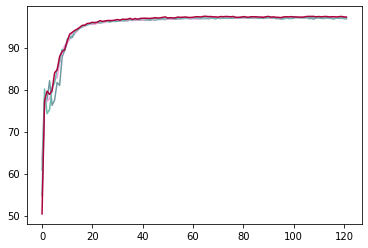

ROUND 121
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389940
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117202
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116294
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.293724
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.226168

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.469217
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086837
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.145029
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.324298
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.196606

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.399989
Model client13 Train Epoch: 2 [0

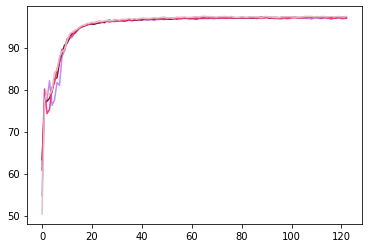

ROUND 122
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.298807
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118923
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038188
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.333218
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.202177

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.468826
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.204161
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.197026
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.417625
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.233338

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

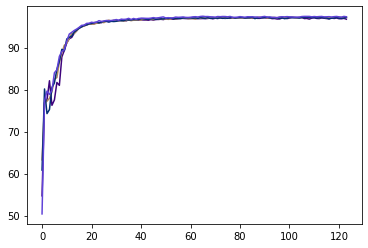

ROUND 123
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.264175
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159119
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018980
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.189516
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.729342

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.493757
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116152
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.262020
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.232108
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.048695

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.444908
Model client13 Train Epoch: 2 [0

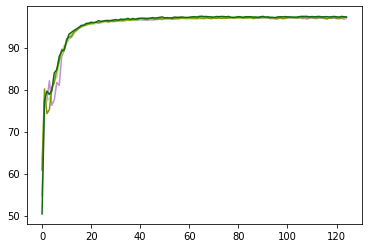

ROUND 124
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.356228
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072679
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.207280
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.340018
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.186950

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.353264
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.150519
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.187424
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.058591
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.894497

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.538849
Model client13 Train Epoch: 2 [0

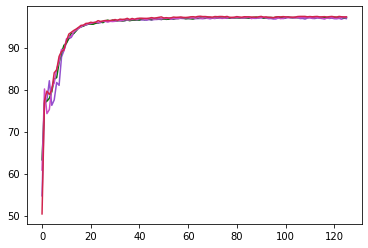

ROUND 125
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.467761
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087131
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.230009
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.497576
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.157062

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.348580
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.218066
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151627
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.487767
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.346388

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.350333
Model client13 Train Epoch: 2 [0

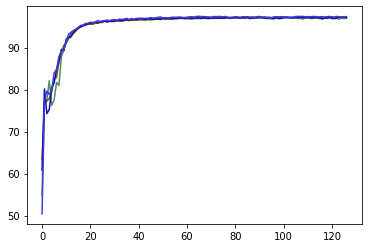

ROUND 126
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.376576
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117347
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048507
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.537337
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.092067

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.321827
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161985
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.172896
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.364210
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.242260

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

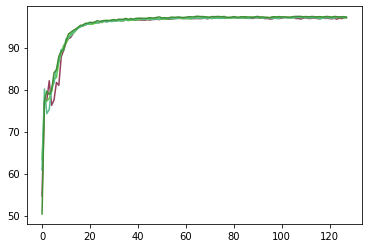

ROUND 127
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.464858
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107568
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.163710
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.291366
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.347937

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.335643
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091232
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.500140
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.478104
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.398289

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.431809
Model client13 Train Epoch: 2 [0

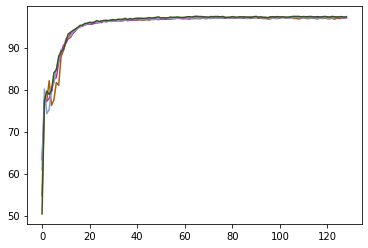

ROUND 128
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.326690
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097024
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.072317
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.782563
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.053573

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.351828
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134209
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.231913
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.298168
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.219304

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.470665
Model client13 Train Epoch: 2 [0

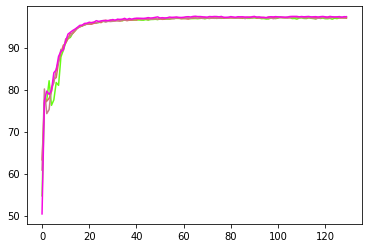

ROUND 129
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.426484
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165522
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077171
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.400325
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.866915

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.515868
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.301358
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.239311
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.442365
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.578696

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.455940
Model client13 Train Epoch: 2 [0

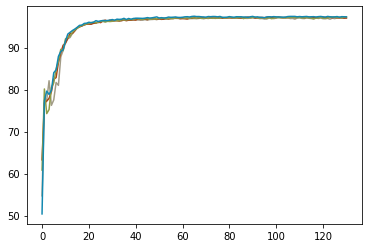

ROUND 130
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.338219
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161708
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.699041
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.694516
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.327824

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.424782
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085622
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.341143
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.953720
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.226359

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.454991
Model client13 Train Epoch: 2 [0

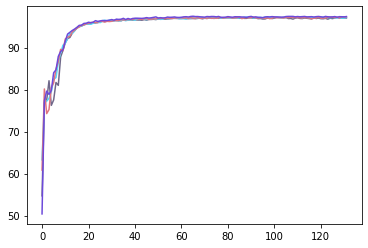

ROUND 131
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.431958
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209357
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.349764
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.726164
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.263928

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.441014
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127316
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.239489
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.068475
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.085955

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.564687
Model client13 Train Epoch: 2 [0

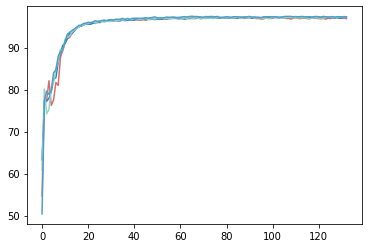

ROUND 132
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.440640
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149211
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071308
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.277195
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.572718

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.373314
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182559
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.475616
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.173340
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.524719

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

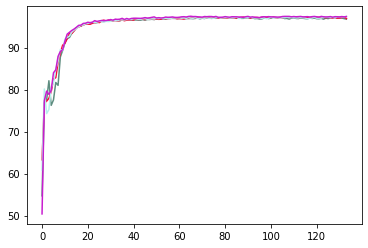

ROUND 133
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.406752
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.251082
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174794
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.318106
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.341847

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.337886
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151734
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.294977
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.098045
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.216860

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.289497
Model client13 Train Epoch: 2 [0

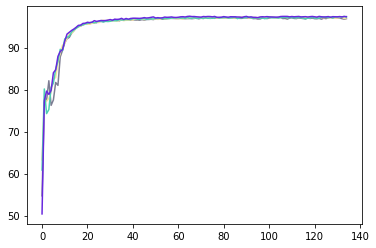

ROUND 134
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.305035
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185337
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.299932
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.161526
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.475217

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.410158
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082990
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.360324
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.272244
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.255145

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.359356
Model client13 Train Epoch: 2 [0

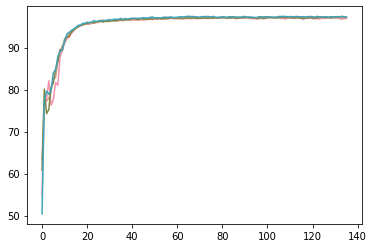

ROUND 135
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.521275
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172195
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110269
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.384475
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.266321

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513927
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.238990
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.322255
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.177686
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.936238

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

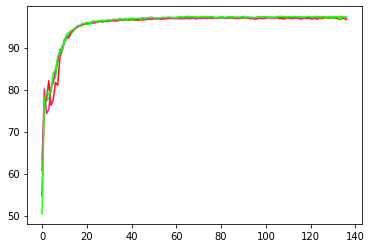

ROUND 136
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.551208
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152883
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132400
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.765957
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.247223

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.426941
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109416
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.103840
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.651344
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.585075

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.436112
Model client13 Train Epoch: 2 [0

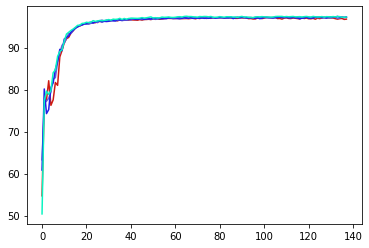

ROUND 137
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.391812
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101603
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.524608
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.148656
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.973624

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.443663
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152719
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.359782
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.149947
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.546519

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.532681
Model client13 Train Epoch: 2 [0

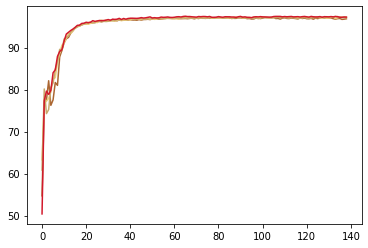

ROUND 138
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.482055
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121250
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052868
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.342025
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.135740

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.372276
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160455
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.298145
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.469311
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.105577

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.407802
Model client13 Train Epoch: 2 [0

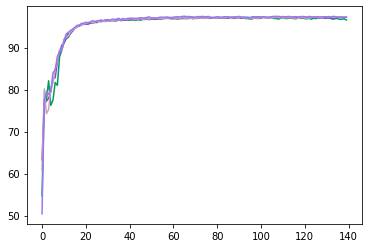

ROUND 139
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.464162
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.196949
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087229
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.344929
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.058625

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.259096
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160944
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.374814
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.263576
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.874889

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417045
Model client13 Train Epoch: 2 [0

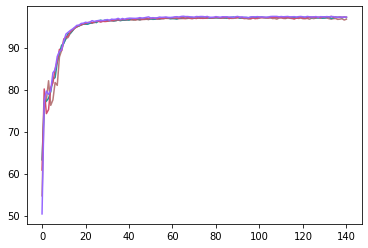

ROUND 140
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.319773
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065787
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.163042
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.319864
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.107258

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.298138
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081139
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.347060
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.055271
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.334494

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.436974
Model client13 Train Epoch: 2 [0

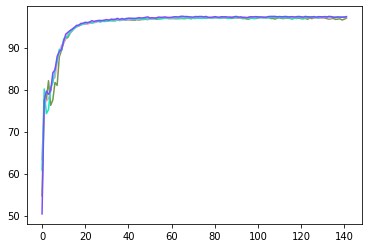

ROUND 141
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389788
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.196944
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.819371
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.541438
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.524380

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513053
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092977
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.182226
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.194931
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.480775

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

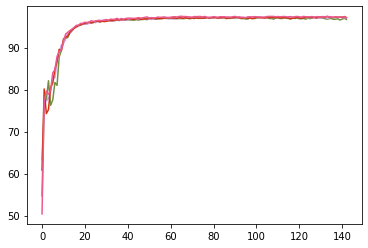

ROUND 142
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.412719
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065312
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117736
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.140069
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.484707

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513496
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120883
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070453
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.205060
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.891263

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.512094
Model client13 Train Epoch: 2 [0

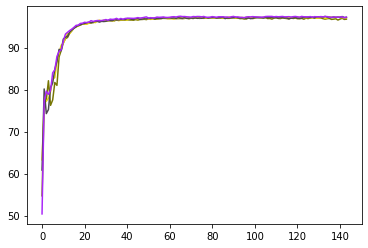

ROUND 143
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.306805
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180137
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.137466
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.753395
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.305132

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.424475
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161852
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.543093
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.974879
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.677004

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.321753
Model client13 Train Epoch: 2 [0

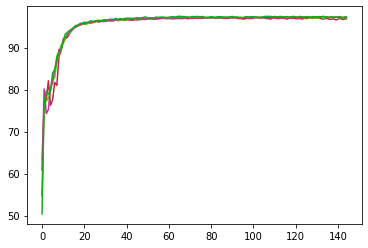

ROUND 144
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.293054
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099162
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.196875
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.086689
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.041574

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.336351
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064852
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.266174
Model client13 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.402082
Model client13 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.993670

Power Allocated= 1.6108117

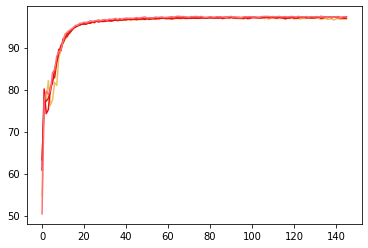

ROUND 145
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.393005
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123099
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097315
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.833506
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.313825

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.342792
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172539
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.090031
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.146223
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.467802

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.352345
Model client13 Train Epoch: 2 [0

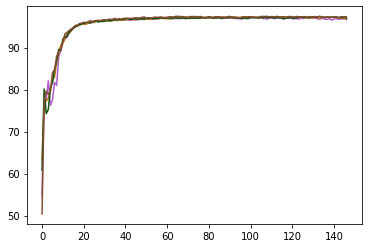

ROUND 146
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.404196
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106998
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.182794
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.403817
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.093431

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040025
CSI= 0.1361480243830283
SNR= 24.04818173100646
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.388788
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.230288
Model client15 Train Epoch: 3 [0/1216 (0%)]	

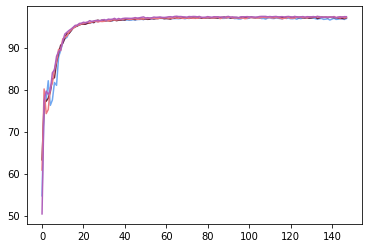

ROUND 147
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389424
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050728
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054685
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.297613
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.778676

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.413208
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085754
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.224256
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.243860
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.564903

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.452926
Model client13 Train Epoch: 2 [0

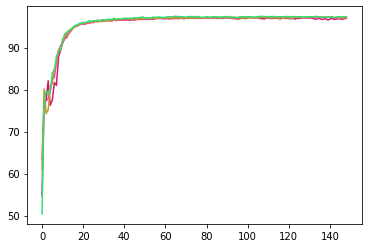

ROUND 148
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.447860
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189392
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102074
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.252986
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.707733

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.420394
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.247062
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.217812
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.156884
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.915899

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435495
Model client13 Train Epoch: 2 [0

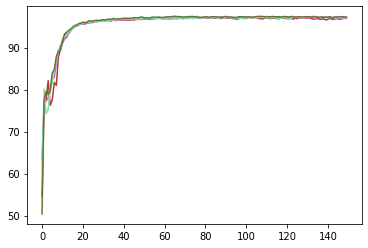

ROUND 149
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.441076
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179875
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.197097
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.785238
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.479757

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.354648
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106806
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.284952
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.012977
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.649116

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.374151
Model client13 Train Epoch: 2 [0

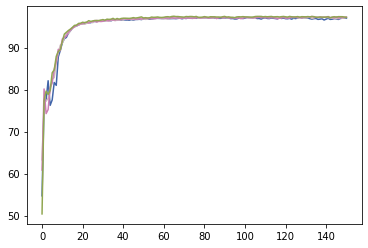

ROUND 150
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.686985
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.247010
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.152246
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.304720
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.401787

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.543992
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197904
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.193540
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.707207
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.410686

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.605675
Model client13 Train Epoch: 2 [0

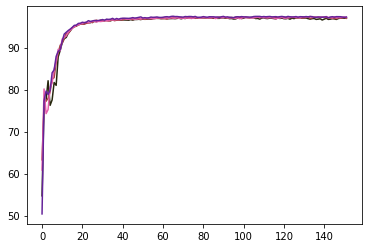

ROUND 151
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.387308
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098373
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016993
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.662358
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.821524

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.295456
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.145051
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.325356
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.407100
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.300009

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435192
Model client13 Train Epoch: 2 [0

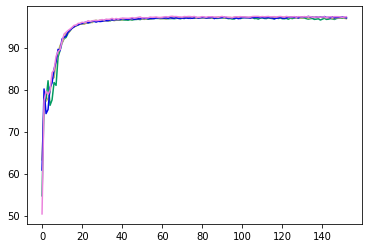

ROUND 152
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.426448
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141293
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.084190
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.128718
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.890793

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.317480
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128494
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126105
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.212532
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.736688

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.375339
Model client13 Train Epoch: 2 [0

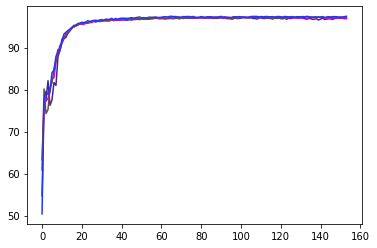

ROUND 153
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.340971
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093180
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.264746
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.577128
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.858378

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.307457
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082644
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.149371
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.125700
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.759584

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.331930
Model client13 Train Epoch: 2 [0

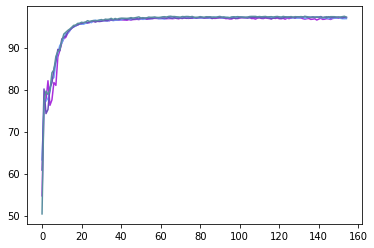

ROUND 154
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.410791
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.175488
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.204020
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.212281
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.410608

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.403384
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178416
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.294756
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.341787
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.309352

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

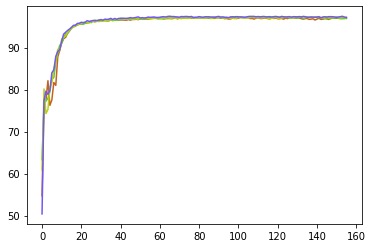

ROUND 155
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363122
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133372
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.135766
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.453346
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.777060

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.560175
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.175496
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.216004
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.387329
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.448718

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.379148
Model client13 Train Epoch: 2 [0

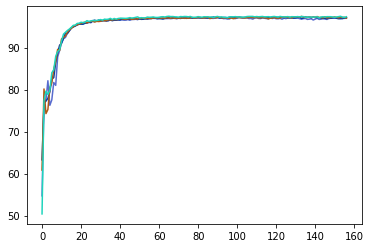

ROUND 156
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.355684
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096804
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.441538
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.449595
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.540578

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.351725
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182222
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.353920
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.409802
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.109596

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.386326
Model client13 Train Epoch: 2 [0

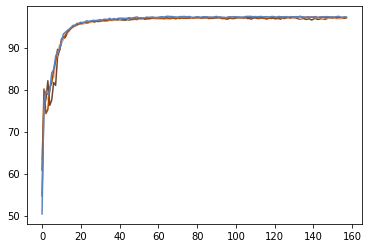

ROUND 157
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.429248
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.143083
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.512053
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.527911
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.229544

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.379847
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181161
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126958
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.202691
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.985988

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

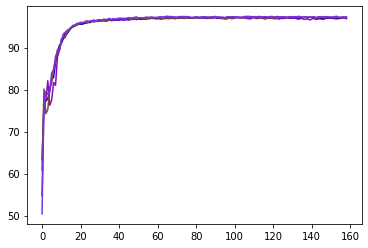

ROUND 158
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.396861
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064645
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.213975
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.129958
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.925807

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.432061
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099750
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051651
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.195392
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.160872

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

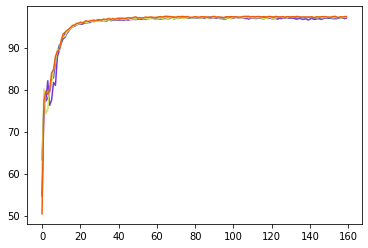

ROUND 159
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.296963
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091740
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185251
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.129099
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.219695

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.440923
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059769
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.179615
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.351627
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.442262

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.520204
Model client13 Train Epoch: 2 [0

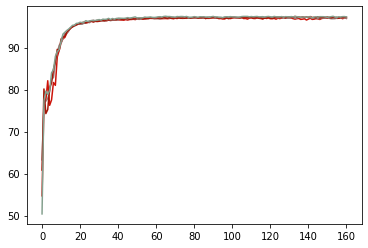

ROUND 160
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.388458
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115556
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070899
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.448087
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.340373

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.299561
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072461
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.213317
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.128427
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.067565

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.412242
Model client13 Train Epoch: 2 [0

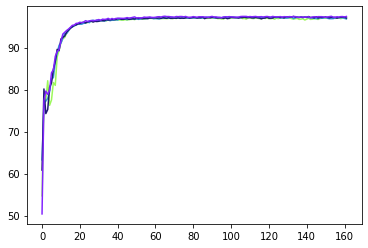

ROUND 161
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.436872
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.282605
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.469550
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.859390
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.532598

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.483111
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066602
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.320112
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.122382
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.457974

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

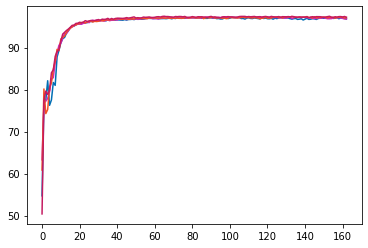

ROUND 162
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.352970
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090792
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.175393
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.323981
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.603273

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.320224
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041024
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.323736
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.088678
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.155395

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.324434
Model client13 Train Epoch: 2 [0

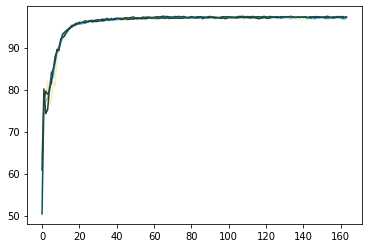

ROUND 163
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.548493
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.213246
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.103329
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.660008
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.357167

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.326734
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.273231
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.626492
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.415416
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.149470

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.586839
Model client13 Train Epoch: 2 [0

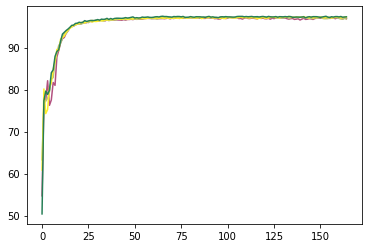

ROUND 164
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.454410
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.449865
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.216853
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.224857
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.077296

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.368834
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160463
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.215176
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.139495
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.951875

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.631449
Model client13 Train Epoch: 2 [0

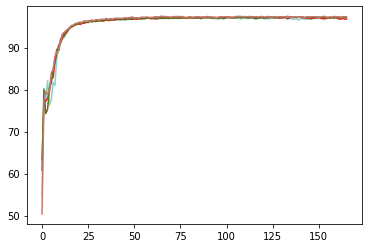

ROUND 165
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.371093
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.529053
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.509205
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.603602
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.201170

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.385699
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.334283
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097977
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.637555
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.321729

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.443395
Model client13 Train Epoch: 2 [0

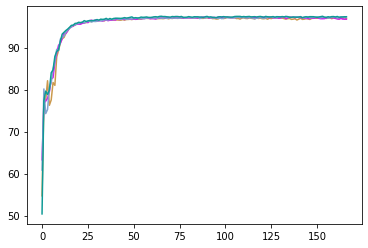

ROUND 166
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.375072
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.283859
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.289058
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.833686
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.950106

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.376126
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104491
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.314720
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.259005
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.909816

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.415416
Model client13 Train Epoch: 2 [0

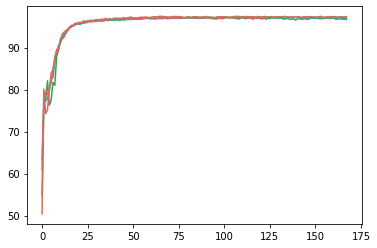

ROUND 167
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.382611
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.244061
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.324656
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.604137
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.950609

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.357640
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.215964
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.142018
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.382540
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.245477

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.349597
Model client13 Train Epoch: 2 [0

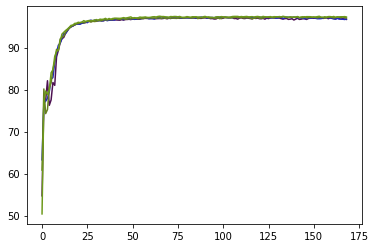

ROUND 168
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363657
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.221353
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.314169
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.148322
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.607112

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.383366
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128071
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.299570
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.782570
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.082216

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.261953
Model client13 Train Epoch: 2 [0

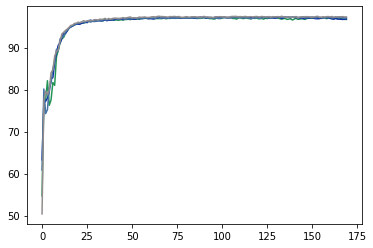

ROUND 169
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.516952
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.386203
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.206724
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.256845
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.571373

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.427361
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082804
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.307455
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.265938
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.498840

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.545971
Model client13 Train Epoch: 2 [0

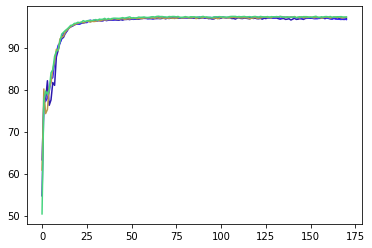

ROUND 170
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.526984
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.341520
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.371125
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.169644
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.590891

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.526154
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.167716
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.308144
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.517144
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.905074

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.794413
Model client13 Train Epoch: 2 [0

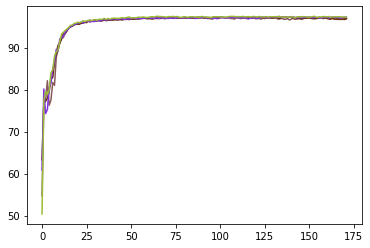

ROUND 171
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.447425
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.242813
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.324748
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.241207
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.558180

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.321397
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179748
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.722512
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.758194
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.766699

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.610186
Model client13 Train Epoch: 2 [0

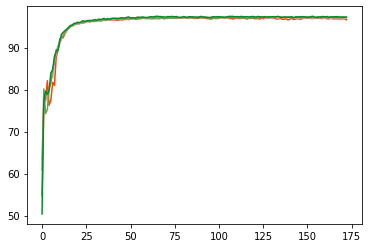

ROUND 172
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.339203
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160692
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.161677
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.135430
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.200098

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.258649
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.263842
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.389804
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.403243
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.152398

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.279799
Model client13 Train Epoch: 2 [0

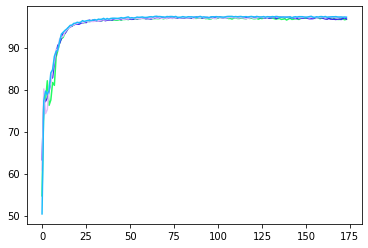

ROUND 173
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.259667
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036175
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086502
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.282562
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.933325

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6108117235040025
CSI= 0.1361480243830283
SNR= 24.04818173100646
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.503104
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.265997
Model client15 Train Epoch: 3 [0/1216 (0%)]	

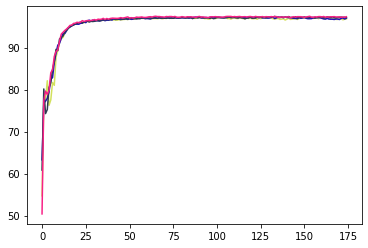

ROUND 174
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327391
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.283386
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.354600
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.653633
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.662390

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.310411
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119903
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.312034
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.222891
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.116456

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.398814
Model client13 Train Epoch: 2 [0

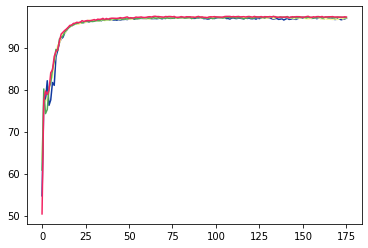

ROUND 175
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.343565
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110308
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.224224
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.208119
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.931443

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.379019
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086063
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.122209
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.650664
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.146347

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

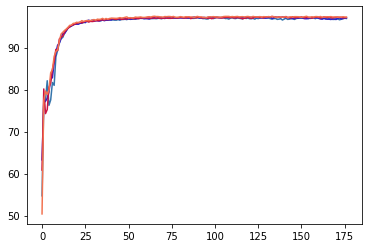

ROUND 176
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.431937
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103504
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.395697
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.844423
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.556798

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.319326
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189165
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.567774
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.539859
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.377603

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.267223
Model client13 Train Epoch: 2 [0

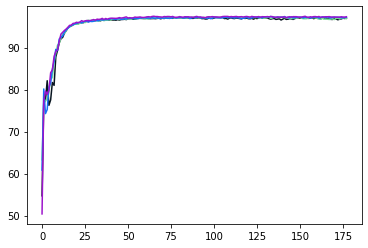

ROUND 177
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.340356
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069321
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.201340
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.315686
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.821106

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.373624
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174162
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.333262
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.320530
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.448516

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.468353
Model client13 Train Epoch: 2 [0

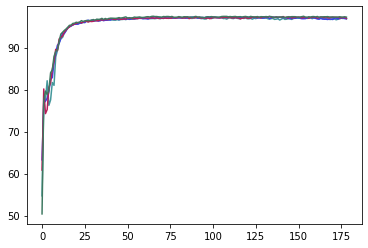

ROUND 178
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.354106
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136091
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.585555
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.237636
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.504039

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.374771
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.219392
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.322821
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.305957
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.217273

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.594196
Model client13 Train Epoch: 2 [0

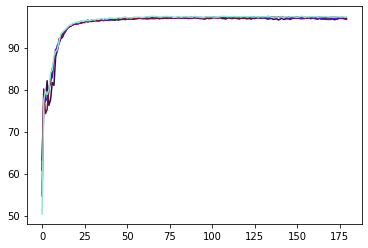

ROUND 179
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417298
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.374365
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054865
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.086344
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.772979

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.302726
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197802
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.225944
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.433054
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.868787

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

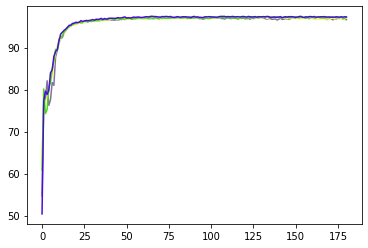

ROUND 180
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.464586
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.206620
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.281027
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.366367
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.449651

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.425392
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227506
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.133107
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.240697
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.085534

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.633829
Model client13 Train Epoch: 2 [0

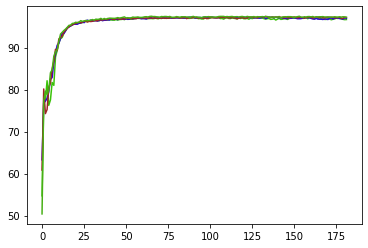

ROUND 181
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.366832
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072848
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.713046
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.827635
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.030814

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.437633
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.144258
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.452813
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.267328
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.108730

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.349157
Model client13 Train Epoch: 2 [0

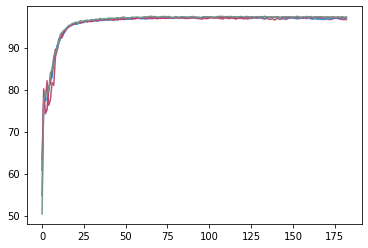

ROUND 182
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.350524
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161237
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174139
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.597324
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.276708

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.353664
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181671
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.209023
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.185885
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.939455

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

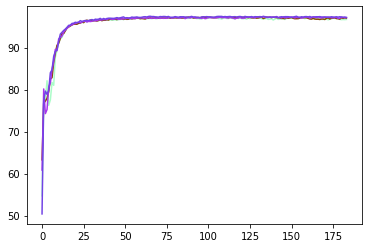

ROUND 183
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.393094
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133524
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.288482
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.514273
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.831811

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.316279
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.285749
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.465073
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.321064
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.565771

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.476337
Model client13 Train Epoch: 2 [0

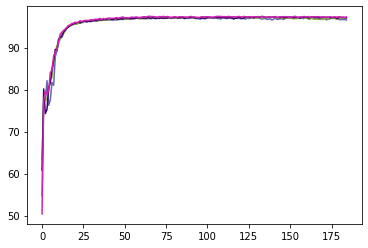

ROUND 184
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.361855
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113852
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.304074
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.692674
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.543298

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.416763
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154812
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.202049
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.318741
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.814444

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.341066
Model client13 Train Epoch: 2 [0

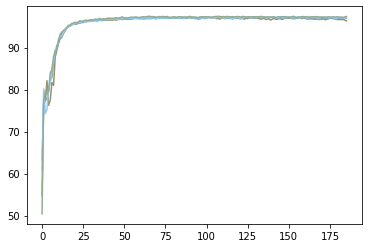

ROUND 185
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.284229
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123842
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.164263
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.204870
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.050886

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.394911
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121739
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.089727
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.568146
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.927383

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

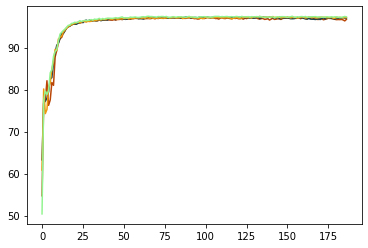

ROUND 186
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.296993
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112720
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.285753
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.043193
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.482607

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.379314
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119167
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.324837
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.132707
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.773084

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513114
Model client13 Train Epoch: 2 [0

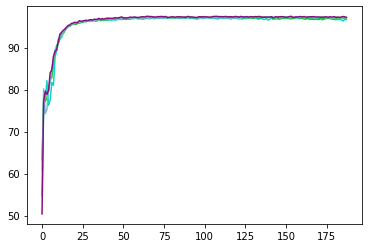

ROUND 187
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.515911
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.167424
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.551005
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.314317
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.748456

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.359378
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.122236
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.384707
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.390747
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.305794

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.492007
Model client13 Train Epoch: 2 [0

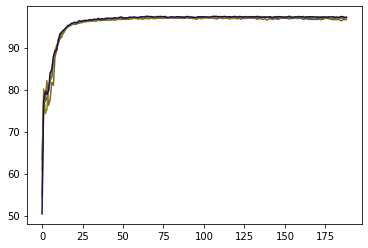

ROUND 188
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.301884
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090912
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.498118
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.214600
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.327333

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.347582
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109910
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126013
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.458622
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.635086

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.427929
Model client13 Train Epoch: 2 [0

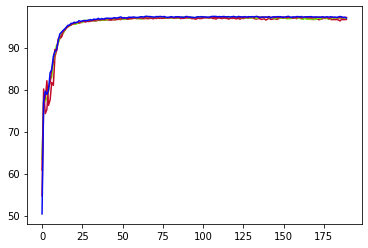

ROUND 189
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.407712
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147701
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.187424
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.667624
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.755816

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.452120
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.251851
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.377248
Model client13 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.688723
Model client13 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.370944

Power Allocated= 1.6108117

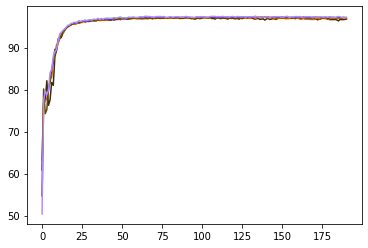

ROUND 190
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.315517
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161882
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.351316
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.758883
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.522216

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.416269
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.196473
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.776477
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 1.388585
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.581378

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.467302
Model client13 Train Epoch: 2 [0

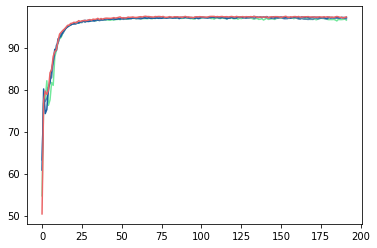

ROUND 191
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.287561
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.126386
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.231587
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.191521
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.623048

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.292307
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142070
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.582066
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.405997
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.245217

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.612434
Model client13 Train Epoch: 2 [0

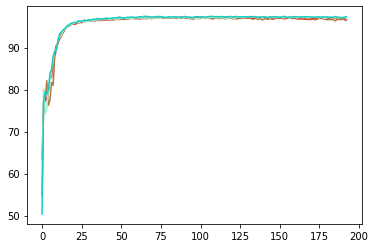

ROUND 192
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.415219
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174270
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.216157
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.268581
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.342437

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.394141
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.405382
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.658600
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.515778
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.247877

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.591121
Model client13 Train Epoch: 2 [0

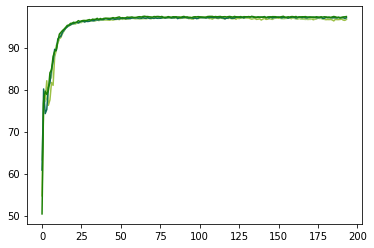

ROUND 193
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.310287
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181795
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.107088
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.405845
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.214721

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.338662
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.240705
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.199256
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.329733
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.472415

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

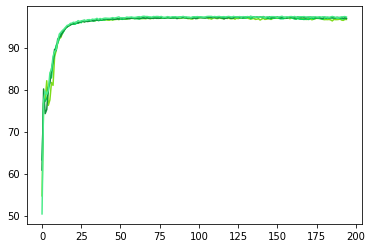

ROUND 194
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.409700
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134400
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.112295
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.092590
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.513512

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.340743
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.208728
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.271385
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.182363
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 1.792011

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

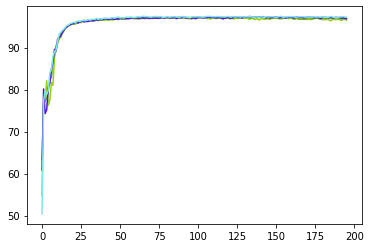

ROUND 195
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.411520
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047493
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134084
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.269032
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.752946

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.406643
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.256371
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.384887
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.316197
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.303897

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.526901
Model client13 Train Epoch: 2 [0

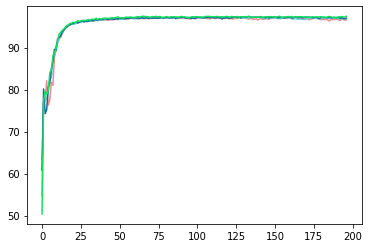

ROUND 196
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.516112
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115123
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.323377
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.129085
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.846517

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.474495
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.340108
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.464131
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.341134
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.566526

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

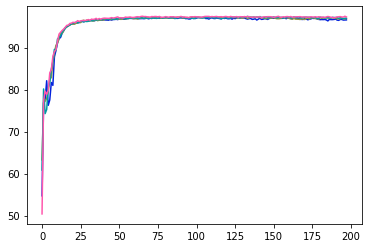

ROUND 197
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.375425
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049981
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.067393
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.105197
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.266065

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.311492
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123669
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.390067
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.000451
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.374889

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389782
Model client13 Train Epoch: 2 [0

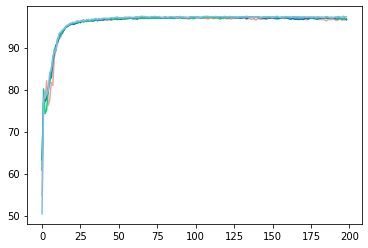

ROUND 198
0.11166000000001385
Power Allocated= 6.6545843904155255
CSI= 0.4345607630959427
SNR= 21.87177882141225
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.385050
Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158431
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.078011
Model client1 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.908316
Model client1 Train Epoch: 5 [0/1216 (0%)]	Loss: 0.917628

Power Allocated= 1.9777244409009063
CSI= 0.1433068374231915
SNR= 27.186185798390138
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.352188
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075259
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.333046
Model client5 Train Epoch: 4 [0/1216 (0%)]	Loss: 0.544113
Model client5 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.201759

Power Allocated= 7.49531823905677
CSI= 0.6847250042504733
SNR= 20.49049267100837
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.610811723504

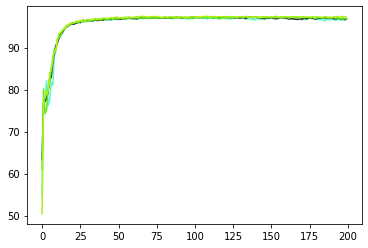

ROUND 199


In [14]:
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)

final_acc=[]
final_loss=[]
    
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters,head_snr_list=cluster_former(args.numclusters,args.clients)
        temp=deepcopy(arranged_clusters)
        temp2=deepcopy(head_snr_list)
    else:
        #print(temp)
        arranged_clusters=deepcopy(temp)
        head_snr_list=deepcopy(temp2)
#     print(arranged_clusters)
    
    no=1
    heads_list=[]
    weights=[]
    weight_head_list=[]
    head_acc=[]
    head_loss=[]
    for cluster in arranged_clusters:
        
        head=cluster['Cluster Head']
        members=cluster['Members']
        snrs=cluster['SNR']
        csis=cluster['CSI']
        weights.append(sum(snrs))
        weight_head_list.append([head,sum(snrs)])
        new_members=[]
        
        for ij in members:
        #print(ij)
            cl_no=int(ij[6:])
            new_members.append(clients[cl_no-1])
#         print(head)
        head=clients[int(head[6:])-1]
        cluster['Members']=new_members
#         print(head)

        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csis:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
        
        print(smallmu1)
        good_mem=[]
#         print(len(snrs))
#         print(len(csis))
#         print(len(new_members))
        index=0
        for client in new_members:
            goodchannel=ClientUpdate(args, device, client,key_np,key,snrs[index],csis[index],smallmu1,head)
            index+=1
            if(goodchannel):
                good_mem.append(client)
        
        head['model']=averageModels(head['model'], good_mem)
        arr=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        ac=arr[0]#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[0]
        no+=1
        heads_list.append(head)
        head_acc.append(ac)
        head_loss.append(arr[1])#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[1])
    
    final_acc.append(head_acc)
    final_loss.append(head_loss)
    fig,ax=plt.subplots()
    clor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(args.numclusters)]
    #ax.plot([i for i in range(fed_round)],head_acc[0])
    for jj in range(0,args.numclusters):
        
        ax.plot([i for i in range(len(final_acc))],[final_acc[j][jj] for j in range(len(final_acc))], color = clor[jj])
        
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][0] for j in range(len(final_acc))], color ="red")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][1] for j in range(len(final_acc))],color ="blue")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][2] for j in range(len(final_acc))],color ="green")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][3] for j in range(len(final_acc))],color ="black")
    #ax.plot([i for i in range(len(final_acc))],head_acc[1], fed_round, color ="blue")
    #ax.plot([i for i in range(len(final_acc))],head_acc[2], fed_round, color ="green")
    #ax.plot([i for i in range(len(final_acc))],head_acc[3], fed_round, color ="black")
    
    
    plt.show()
    weightsum=sum(weights)
    
    weights[:] = [x / weightsum for x in weights]
    for aah in range(len(weight_head_list)):
        weight_head_list[aah][1]=weights[aah]
    final_heads,nets=decentralized(heads_list,head_snr_list,weight_head_list)
    
    for head in range(len(final_heads)):
        for cluster in arranged_clusters:
            head1=cluster['Cluster Head']
            if(head1==final_heads[head]['hook'].id):
                for mem in cluster['Members']:
                    mem['model'].load_state_dict(nets[head].state_dict())
    print("ROUND",fed_round)

In [15]:
print(final_acc)

[[54.69, 63.25, 60.82, 50.38], [76.93, 76.75, 80.14, 77.32], [77.51, 77.24, 74.27, 79.63], [82.1, 77.91, 75.24, 78.84], [76.24, 79.49, 80.49, 79.82], [77.53, 82.5, 81.58, 84.0], [81.68, 82.84, 84.83, 84.7], [81.0, 86.48, 86.71, 87.9], [87.77, 88.72, 89.58, 89.07], [89.32, 90.55, 89.26, 89.48], [91.14, 91.02, 92.04, 91.53], [92.11, 92.23, 92.43, 93.21], [92.42, 93.4, 92.74, 93.63], [93.43, 93.34, 93.67, 94.07], [94.0, 94.01, 94.17, 94.41], [94.68, 94.66, 94.59, 94.82], [95.02, 94.92, 94.93, 95.29], [95.12, 95.15, 95.29, 95.34], [95.44, 95.4, 95.39, 95.75], [95.59, 95.58, 95.65, 95.8], [95.73, 95.57, 95.73, 96.03], [95.71, 95.56, 95.94, 95.93], [95.9, 95.78, 96.03, 96.04], [95.95, 95.82, 95.87, 96.41], [95.92, 96.13, 96.09, 96.23], [96.17, 95.93, 96.23, 96.33], [96.22, 96.37, 96.29, 96.45], [96.2, 96.53, 96.08, 96.4], [96.34, 96.29, 96.25, 96.45], [96.27, 96.55, 96.2, 96.53], [96.42, 96.33, 96.26, 96.67], [96.39, 96.39, 96.43, 96.52], [96.66, 96.4, 96.39, 96.76], [96.47, 96.31, 96.4, 96.